In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Function to calculate SOFA score components based on metrics
def calculate_sofa_components(row):
    """Calculate SOFA score components for each organ system"""
    scores = {}
    
    # Respiratory system - PaO2/FiO2 ratio
    if 'pf_ratio' in row and not pd.isna(row['pf_ratio']):
        pf_ratio = row['pf_ratio']
        # Check if patient is on ventilator
        vent = row.get('is_ventilated', 0)
        
        if pf_ratio < 100 and vent == 1:
            scores['respiratory'] = 4
        elif pf_ratio < 200 and vent == 1:
            scores['respiratory'] = 3
        elif pf_ratio < 300:
            scores['respiratory'] = 2
        elif pf_ratio < 400:
            scores['respiratory'] = 1
        else:
            scores['respiratory'] = 0
    else:
        # Use SpO2/FiO2 as alternative if available
        spo2 = row.get('spo2', None)
        fio2 = row.get('fio2', None)
        if not pd.isna(spo2) and not pd.isna(fio2) and fio2 > 0:
            sf_ratio = (spo2 / fio2) * 100
            if sf_ratio < 89:
                scores['respiratory'] = 4
            elif sf_ratio < 214:
                scores['respiratory'] = 3
            elif sf_ratio < 357:
                scores['respiratory'] = 2
            elif sf_ratio < 512:
                scores['respiratory'] = 1
            else:
                scores['respiratory'] = 0
        else:
            scores['respiratory'] = np.nan
    
    # Cardiovascular system - Blood pressure / using vasopressors
    # Note: Since we don't have vasopressor data, using just MAP
    if 'mbp' in row and not pd.isna(row['mbp']):
        mbp = row['mbp']
        if mbp < 70:
            scores['cardiovascular'] = 1
        else:
            scores['cardiovascular'] = 0
    else:
        scores['cardiovascular'] = np.nan
    
    # CNS - Glasgow Coma Scale (not available, skipping)
    scores['cns'] = np.nan
    
    # Renal - Creatinine or urine output
    # Using only urine output as creatinine might not be in dataset
    if 'urine_output' in row and not pd.isna(row['urine_output']):
        urine = row['urine_output']
        # SOFA score uses urine per day, so this is approximate
        if urine < 200:  # Very low output per 6-hour period
            scores['renal'] = 4
        elif urine < 500:  # Low output per 12-hour period
            scores['renal'] = 3
        else:
            scores['renal'] = 0
    else:
        scores['renal'] = np.nan
    
    # Liver - Bilirubin (might not be available)
    scores['liver'] = np.nan
    
    # Coagulation - Platelets
    if 'platelets' in row and not pd.isna(row['platelets']):
        platelets = row['platelets']
        if platelets < 20:
            scores['coagulation'] = 4
        elif platelets < 50:
            scores['coagulation'] = 3
        elif platelets < 100:
            scores['coagulation'] = 2
        elif platelets < 150:
            scores['coagulation'] = 1
        else:
            scores['coagulation'] = 0
    else:
        scores['coagulation'] = np.nan
    
    # Approximate total score - taking mean of available components and scaling
    available_scores = [v for v in scores.values() if not np.isnan(v)]
    if len(available_scores) > 0:
        avg_score = sum(available_scores) / len(available_scores)
        # Scale to approximate full SOFA range (0-24)
        scores['total'] = min(avg_score * (24/4), 24)  # Cap at 24
    else:
        scores['total'] = np.nan
    
    return scores

def create_sofa_over_time_visualization(df_path, num_patients=5):
    """
    Create a visualization of SOFA scores for patients over time
    
    Args:
        df_path: Path to the CSV file with patient data
        num_patients: Number of patients to visualize
    """
    # Load the data
    try:
        df = pd.read_csv(df_path)
        print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None
    
    # Check for patients with most complete data
    metric_columns = [col for col in df.columns if any(f"_{t}min" in col for t in range(0, 1440, 30))]
    
    # Get the unique patient IDs
    patient_ids = df['patient_id'].unique()
    
    # If there are more than num_patients, sample a subset
    # Prioritize patients with mortality=1 if that column exists
    if len(patient_ids) > num_patients:
        if 'icu_mortality' in df.columns:
            # Get some patients who died and some who survived
            died_patients = df[df['icu_mortality'] == 1]['patient_id'].unique()
            survived_patients = df[df['icu_mortality'] == 0]['patient_id'].unique()
            
            # Select a balanced mix if possible
            if len(died_patients) >= num_patients // 2 and len(survived_patients) >= num_patients // 2:
                died_sample = np.random.choice(died_patients, num_patients // 2, replace=False)
                survived_sample = np.random.choice(survived_patients, num_patients - len(died_sample), replace=False)
                patient_ids = np.concatenate([died_sample, survived_sample])
            else:
                # Otherwise just select randomly
                patient_ids = np.random.choice(patient_ids, num_patients, replace=False)
        else:
            # Random selection if no mortality data
            patient_ids = np.random.choice(patient_ids, num_patients, replace=False)
    
    # Filter to selected patients
    patients_df = df[df['patient_id'].isin(patient_ids)]
    
    # Get the time points (minutes from admission) - FIXED CODE HERE
    time_points = []
    for col in df.columns:
        # More robust pattern matching to extract time points
        parts = col.split('_')
        if len(parts) >= 2 and parts[-1].endswith('min'):
            try:
                # Try to extract and convert the numeric part
                time_str = parts[-1].replace('min', '')
                # Only add if it's a valid number
                if time_str.isdigit():
                    time_points.append(int(time_str))
            except (ValueError, IndexError):
                # Skip columns that don't fit the expected pattern
                continue
    
    # Remove duplicates and sort
    time_points = sorted(list(set(time_points)))
    
    if not time_points:
        print("Error: No valid time points found in the dataset columns")
        return None
    
    print(f"Found {len(time_points)} time points: {time_points}")
    
    # Calculate SOFA scores for each patient at each time point
    patient_scores = {}
    
    for patient_id in patient_ids:
        patient_data = patients_df[patients_df['patient_id'] == patient_id].iloc[0]
        patient_scores[patient_id] = {}
        
        for time_point in time_points:
            # Extract measurements for this time point
            time_data = {}
            for metric in ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 
                           'fio2', 'sao2', 'is_ventilated', 'pf_ratio', 'wbc', 
                           'platelets', 'lactate', 'pao2', 'pco2', 'urine_output']:
                col = f"{metric}_{time_point}min"
                if col in patient_data:
                    time_data[metric] = patient_data[col]
            
            # Calculate SOFA scores for this time point
            sofa_components = calculate_sofa_components(time_data)
            patient_scores[patient_id][time_point] = sofa_components
    
    # Create plots
    create_visualization(patient_scores, patients_df, time_points)

def create_visualization(patient_scores, patients_df, time_points):
    """Create visualizations for the calculated patient scores"""
    
    # Set up the figure
    n_patients = len(patient_scores)
    fig = plt.figure(figsize=(15, n_patients * 3 + 3))
    gs = gridspec.GridSpec(n_patients + 1, 2, width_ratios=[5, 1], height_ratios=[1] + [3] * n_patients)
    
    # Create a custom colormap for SOFA scores
    colors = [(0, 0.7, 0), (1, 1, 0), (1, 0.5, 0), (1, 0, 0)]  # Green to yellow to orange to red
    cmap = LinearSegmentedColormap.from_list('sofa_cmap', colors, N=25)
    
    # Plot title and legend
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.axis('off')
    ax_title.text(0.5, 0.5, 'SOFA Score Progression Over First 24 Hours of ICU Stay', 
                  fontsize=18, fontweight='bold', ha='center')
    
    # Create legend patches
    legend_elements = [
        mpatches.Patch(color=cmap(0), label='SOFA = 0 (No organ dysfunction)'),
        mpatches.Patch(color=cmap(6), label='SOFA = 6 (Organ dysfunction)'),
        mpatches.Patch(color=cmap(12), label='SOFA = 12 (Severe dysfunction)'),
        mpatches.Patch(color=cmap(18), label='SOFA = 18 (Very severe dysfunction)'),
        mpatches.Patch(color=cmap(24), label='SOFA = 24 (Maximum score)')
    ]
    ax_title.legend(handles=legend_elements, loc='center', ncol=5, fontsize=10)
    
    # Plot each patient's data
    for i, (patient_id, scores) in enumerate(patient_scores.items(), 1):
        # Main plot for SOFA score trends
        ax_main = fig.add_subplot(gs[i, 0])
        
        # Get mortality information if available
        mortality_info = ""
        if 'icu_mortality' in patients_df.columns:
            mortality = patients_df[patients_df['patient_id'] == patient_id]['icu_mortality'].iloc[0]
            mortality_info = f" - {'Deceased in ICU' if mortality == 1 else 'Survived ICU'}"
        
        ax_main.set_title(f"Patient {patient_id}{mortality_info}", fontsize=12, fontweight='bold')
        
        # Extract SOFA total scores for line plot
        sofa_totals = []
        for tp in time_points:
            if tp in scores and 'total' in scores[tp]:
                sofa_totals.append(scores[tp]['total'])
            else:
                sofa_totals.append(np.nan)
        
        # Plot total SOFA score
        ax_main.plot(time_points, sofa_totals, 'k-', linewidth=2, label='Total SOFA Score')
        
        # Color the background based on the SOFA score severity
        for j in range(len(time_points) - 1):
            if not np.isnan(sofa_totals[j]):
                ax_main.axvspan(time_points[j], time_points[j+1], 
                              ymin=0, ymax=1, 
                              color=cmap(int(sofa_totals[j])), 
                              alpha=0.3)
        
        # Plot vertical lines for every 6 hours
        for hour in [0, 360, 720, 1080, 1440]:
            ax_main.axvline(x=hour, color='gray', linestyle='--', alpha=0.7)
        
        # Label axes
        ax_main.set_xlabel('Minutes from ICU Admission', fontsize=10)
        ax_main.set_ylabel('SOFA Score', fontsize=10)
        ax_main.set_xlim(0, max(time_points))
        ax_main.set_ylim(0, 24)
        ax_main.grid(True, alpha=0.3)
        
        # Add hour labels
        hour_labels = ['0h', '6h', '12h', '18h', '24h']
        hour_positions = [0, 360, 720, 1080, 1440]
        ax_main.set_xticks(hour_positions)
        ax_main.set_xticklabels(hour_labels)
        
        # Component heatmap for this patient
        ax_components = fig.add_subplot(gs[i, 1])
        ax_components.set_title("Components", fontsize=10)
        
        # Prepare component data for heatmap
        components = ['respiratory', 'cardiovascular', 'coagulation', 'renal']
        component_data = []
        
        for component in components:
            component_scores = []
            for tp in time_points:
                if tp in scores and component in scores[tp]:
                    component_scores.append(scores[tp][component])
                else:
                    component_scores.append(np.nan)
            # Take average of component scores over time (excluding NaN)
            valid_scores = [s for s in component_scores if not np.isnan(s)]
            if valid_scores:
                component_data.append(np.nanmean(component_scores))
            else:
                component_data.append(np.nan)
        
        # Plot the component heatmap
        sns.heatmap([component_data], ax=ax_components, cmap=cmap, 
                    cbar=False, annot=True, fmt=".1f", 
                    xticklabels=[c[:3] for c in components], 
                    yticklabels=["Avg"])
        
        # Customize component heatmap
        ax_components.set_yticks([])
        ax_components.set_xlabel("")
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    
    # Save the figure
    plt.savefig('patient_sofa_visualization.png', dpi=300, bbox_inches='tight')
    print("Visualization saved as 'patient_sofa_visualization.png'")
    
    return plt.gcf()

# Main execution
if __name__ == "__main__":
    # Replace with your actual file path
    df_path = "mimic_expanded_metrics_24hr.csv"
    
    # Create the visualization for 5 patients
    create_sofa_over_time_visualization(df_path, num_patients=5)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def prepare_data(df_path):
    """
    Load and prepare data for mortality prediction model training
    
    Args:
        df_path: Path to the CSV file with patient data
        
    Returns:
        Tuple of dataframes (patients_df, time_points, feature_names)
    """
    # Load the data
    try:
        df = pd.read_csv(df_path)
        print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None, None
    
    # Extract time points from column names
    time_points = []
    for col in df.columns:
        parts = col.split('_')
        if len(parts) >= 2 and parts[-1].endswith('min'):
            try:
                time_str = parts[-1].replace('min', '')
                if time_str.isdigit():
                    time_points.append(int(time_str))
            except (ValueError, IndexError):
                continue
    
    # Remove duplicates and sort
    time_points = sorted(list(set(time_points)))
    
    if not time_points:
        print("Error: No valid time points found in the dataset columns")
        return None, None, None
    
    print(f"Found {len(time_points)} time points: {time_points}")
    
    # Define relevant clinical features for prediction
    base_features = [
        'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 
        'fio2', 'is_ventilated', 'pf_ratio', 'wbc', 
        'platelets', 'lactate', 'pao2', 'pco2', 'temperature',
        'urine_output', 'glucose'
    ]
    
    # Check which features are actually in the dataset
    available_features = []
    for feature in base_features:
        # Check if at least one time point has this feature
        if any(f"{feature}_{tp}min" in df.columns for tp in time_points):
            available_features.append(feature)
    
    print(f"Using {len(available_features)} available features: {available_features}")
    
    # Verify target variable exists
    if 'icu_mortality' not in df.columns:
        print("Warning: 'icu_mortality' column not found in dataset")
        print("Creating dummy mortality column for demonstration")
        # Create dummy mortality data for demonstration if real data not available
        np.random.seed(42)
        df['icu_mortality'] = np.random.binomial(1, 0.15, size=df.shape[0])
    
    # Get patient demographics if available
    demo_cols = ['age', 'gender', 'weight', 'height', 'bmi']
    demo_available = [col for col in demo_cols if col in df.columns]
    
    print(f"Available demographic features: {demo_available}")
    
    return df, time_points, available_features, demo_available

# Example usage
if __name__ == "__main__":
    df_path = "mimic_expanded_metrics_24hr.csv"
    df, time_points, features, demo_cols = prepare_data(df_path)

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

def train_time_based_mortality_models(df, time_points, features, demo_cols):
    """
    Train XGBoost models for mortality prediction at each time point
    
    Args:
        df: DataFrame with patient data
        time_points: List of time points (minutes)
        features: List of clinical features to use
        demo_cols: List of demographic features to use
        
    Returns:
        Dictionary of trained models for each time point
    """
    # Ensure we have a target variable
    if 'icu_mortality' not in df.columns:
        print("Error: Target variable 'icu_mortality' not found")
        return None
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Split patients into train and test sets (stratified by mortality)
    patient_ids = df['patient_id'].unique()
    mortality_by_patient = df.groupby('patient_id')['icu_mortality'].first()
    
    train_ids, test_ids = train_test_split(
        patient_ids, 
        test_size=0.2, 
        random_state=42,
        stratify=mortality_by_patient.loc[patient_ids].values
    )
    
    print(f"Training with {len(train_ids)} patients, testing with {len(test_ids)} patients")
    
    # Initialize models and performance dictionaries
    models = {}
    auc_scores = {}
    feature_importance_dfs = {}
    
    # Train a separate model for each time point
    for time_point in time_points:
        print(f"\nTraining model for {time_point} minutes after admission...")
        
        # Prepare feature matrix with data available at this time point
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        
        # Demographics features don't change over time
        demo_features = []
        
        # Only use time points up to and including current time point
        valid_tps = [tp for tp in time_points if tp <= time_point]
        
        # For training data
        for patient_id in train_ids:
            patient_data = df[df['patient_id'] == patient_id].iloc[0]
            
            # Get outcome (mortality)
            mortality = patient_data['icu_mortality']
            
            # Get feature values for this patient at each time point up to current
            patient_features = []
            
            # Add demographics (if available)
            if demo_cols:
                for col in demo_cols:
                    if col in patient_data:
                        patient_features.append(patient_data[col])
                        if len(demo_features) < len(demo_cols):
                            demo_features.append(col)
            
            # Add clinical features up to current time point
            for tp in valid_tps:
                for feature in features:
                    col_name = f"{feature}_{tp}min"
                    if col_name in patient_data:
                        value = patient_data[col_name]
                        patient_features.append(value)
                    else:
                        # Add NaN if column doesn't exist to ensure consistent feature count
                        patient_features.append(np.nan)
            
            # Add trends (delta from previous time point) if more than one time point
            if len(valid_tps) > 1 and valid_tps[-1] > valid_tps[0]:
                for feature in features:
                    curr_col = f"{feature}_{valid_tps[-1]}min"
                    prev_col = f"{feature}_{valid_tps[-2]}min"
                    if curr_col in patient_data and prev_col in patient_data:
                        curr_val = patient_data[curr_col]
                        prev_val = patient_data[prev_col]
                        if not pd.isna(curr_val) and not pd.isna(prev_val):
                            trend = curr_val - prev_val
                            patient_features.append(trend)
                    else:
                        # Add NaN to keep feature count consistent
                        patient_features.append(np.nan)
            
            X_train.append(patient_features)
            y_train.append(mortality)
        
        # For test data
        for patient_id in test_ids:
            patient_data = df[df['patient_id'] == patient_id].iloc[0]
            
            # Get outcome (mortality)
            mortality = patient_data['icu_mortality']
            
            # Get feature values for this patient at each time point up to current
            patient_features = []
            
            # Add demographics (if available)
            if demo_cols:
                for col in demo_cols:
                    if col in patient_data:
                        patient_features.append(patient_data[col])
            
            # Add clinical features up to current time point
            for tp in valid_tps:
                for feature in features:
                    col_name = f"{feature}_{tp}min"
                    if col_name in patient_data:
                        value = patient_data[col_name]
                        patient_features.append(value)
                    else:
                        # Add NaN if column doesn't exist to ensure consistent feature count
                        patient_features.append(np.nan)
            
            # Add trends (delta from previous time point) if more than one time point
            if len(valid_tps) > 1 and valid_tps[-1] > valid_tps[0]:
                for feature in features:
                    curr_col = f"{feature}_{valid_tps[-1]}min"
                    prev_col = f"{feature}_{valid_tps[-2]}min"
                    if curr_col in patient_data and prev_col in patient_data:
                        curr_val = patient_data[curr_col]
                        prev_val = patient_data[prev_col]
                        if not pd.isna(curr_val) and not pd.isna(prev_val):
                            trend = curr_val - prev_val
                            patient_features.append(trend)
                    else:
                        # Add NaN to keep feature count consistent
                        patient_features.append(np.nan)
            
            X_test.append(patient_features)
            y_test.append(mortality)
        
        # Check if feature vectors have consistent lengths
        feature_lengths_train = [len(x) for x in X_train]
        feature_lengths_test = [len(x) for x in X_test]
        
        if len(set(feature_lengths_train)) > 1 or len(set(feature_lengths_test)) > 1:
            print(f"Warning: Inconsistent feature vector lengths detected")
            print(f"Train lengths: {set(feature_lengths_train)}")
            print(f"Test lengths: {set(feature_lengths_test)}")
            
            # Find the maximum feature length
            max_length = max(max(feature_lengths_train), max(feature_lengths_test))
            
            # Pad shorter vectors with NaN
            for i in range(len(X_train)):
                if len(X_train[i]) < max_length:
                    X_train[i] = X_train[i] + [np.nan] * (max_length - len(X_train[i]))
            
            for i in range(len(X_test)):
                if len(X_test[i]) < max_length:
                    X_test[i] = X_test[i] + [np.nan] * (max_length - len(X_test[i]))
        
        # Convert to numpy arrays
        try:
            X_train = np.array(X_train, dtype=float)
            y_train = np.array(y_train)
            X_test = np.array(X_test, dtype=float)
            y_test = np.array(y_test)
            
            print(f"Feature matrix shapes - Train: {X_train.shape}, Test: {X_test.shape}")
        except ValueError as e:
            print(f"Error creating arrays: {e}")
            # Debug information
            if len(X_train) > 0:
                print(f"First training example length: {len(X_train[0])}")
                print(f"Feature vector lengths in training set: {[len(x) for x in X_train[:5]]}...")
            return None, None
        
        # Handle missing values
        imputer = SimpleImputer(strategy='median')
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)
        
        # Normalize features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Train XGBoost model
        model = xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=4,
            min_child_weight=2,
            gamma=0.2,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            eval_metric='auc',
            use_label_encoder=False,
            random_state=42
        )
        
        # Train model with eval set
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        # Use the model's best iteration if early stopping was used
        # Note: XGBoost will automatically use the best iteration when predicting
        
        # Evaluate on test set
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Time point {time_point}min - AUC: {auc:.3f}, Accuracy: {accuracy:.3f}")
        print(classification_report(y_test, y_pred))
        
        # Store model and performance
        models[time_point] = {
            'model': model,
            'imputer': imputer,
            'scaler': scaler,
            'auc': auc,
            'accuracy': accuracy,
            'feature_len': X_train.shape[1]
        }
        
        auc_scores[time_point] = auc
        
        # Feature importance
        if hasattr(model, 'feature_importances_'):
            # Create feature names list
            feature_names = []
            
            # Add demographic feature names
            feature_names.extend(demo_features)
            
            # Add clinical feature names with time points
            for tp in valid_tps:
                for feature in features:
                    feature_names.append(f"{feature}_{tp}min")
            
            # Add trend feature names if applicable
            if len(valid_tps) > 1:
                for feature in features:
                    feature_names.append(f"{feature}_trend")
            
            # Ensure feature names list matches the number of features used
            if len(feature_names) > X_train.shape[1]:
                feature_names = feature_names[:X_train.shape[1]]
            elif len(feature_names) < X_train.shape[1]:
                # Add generic names for any missing feature names
                for i in range(len(feature_names), X_train.shape[1]):
                    feature_names.append(f"feature_{i}")
            
            # Get feature importances
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            # Create DataFrame with feature importances
            importance_df = pd.DataFrame({
                'Feature': [feature_names[i] if i < len(feature_names) else f"feature_{i}" for i in indices],
                'Importance': importances[indices]
            })
            
            feature_importance_dfs[time_point] = importance_df
    
    # Plot AUC over time
    plt.figure(figsize=(10, 6))
    plt.plot(list(auc_scores.keys()), list(auc_scores.values()), 'o-', linewidth=2)
    plt.xlabel('Minutes from ICU Admission')
    plt.ylabel('AUC Score')
    plt.title('Mortality Prediction Performance Over Time')
    plt.grid(True, alpha=0.3)
    
    # Add hour labels
    hours = [0, 6, 12, 18, 24]
    hour_positions = [h * 60 for h in hours]
    plt.xticks(hour_positions, [f'{h}h' for h in hours])
    
    plt.tight_layout()
    plt.savefig('mortality_prediction_performance.png', dpi=300)
    plt.show()
    
    return models, feature_importance_dfs

# Example usage
if __name__ == "__main__":
    # Load prepared data from previous cell
    df_path = "mimic_expanded_metrics_24hr.csv"
    df, time_points, features, demo_cols = prepare_data(df_path)
    
    # Train models for each time point
    models, feature_importances = train_time_based_mortality_models(df, time_points, features, demo_cols)
    
    # Save models for later use
    with open('time_based_mortality_models.pkl', 'wb') as f:
        pickle.dump(models, f)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import pickle
import warnings
warnings.filterwarnings('ignore')

def prepare_time_aware_data(df, time_points, features):
    """
    Prepare data for time-aware mortality prediction
    
    Args:
        df: DataFrame with patient data
        time_points: List of time points (minutes)
        features: List of clinical features to use
        
    Returns:
        Dictionary with prepared data for each time point
    """
    print(f"Preparing time-aware data for {len(df['patient_id'].unique())} patients...")
    
    # Verify mortality data exists
    if 'icu_mortality' not in df.columns:
        print("Warning: Creating synthetic mortality outcome for demonstration")
        np.random.seed(42)
        df['icu_mortality'] = np.random.binomial(1, 0.15, size=df.shape[0])
    
    # Get patient IDs
    patient_ids = df['patient_id'].unique()
    
    # Split patients into train and test sets
    mortality_by_patient = df.groupby('patient_id')['icu_mortality'].first()
    
    train_ids, test_ids = train_test_split(
        patient_ids, 
        test_size=0.2, 
        random_state=42,
        stratify=mortality_by_patient.loc[patient_ids].values
    )
    
    print(f"Training with {len(train_ids)} patients, testing with {len(test_ids)} patients")
    
    # Prepare data for each time point
    time_point_data = {}
    
    for time_point in sorted(time_points):
        # Only use data available up to this time point
        available_tps = [tp for tp in time_points if tp <= time_point]
        
        # Features and targets for this time point
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        
        # Process training data
        for patient_id in train_ids:
            patient_data = df[df['patient_id'] == patient_id].iloc[0]
            
            # Get outcome (mortality)
            mortality = patient_data['icu_mortality']
            
            # Extract features available at this time point
            patient_features = []
            
            # Basic patient info (age if available)
            if 'age' in patient_data:
                patient_features.append(patient_data['age'])
            
            # Clinical features at available time points
            for tp in available_tps:
                for feature in features:
                    col_name = f"{feature}_{tp}min"
                    if col_name in patient_data:
                        patient_features.append(patient_data[col_name])
                    else:
                        patient_features.append(np.nan)
            
            # Add trends for last two time points if we have at least two measurements
            if len(available_tps) >= 2:
                latest_tp = available_tps[-1]
                prev_tp = available_tps[-2]
                
                for feature in features:
                    latest_col = f"{feature}_{latest_tp}min"
                    prev_col = f"{feature}_{prev_tp}min"
                    
                    if latest_col in patient_data and prev_col in patient_data:
                        latest_val = patient_data[latest_col]
                        prev_val = patient_data[prev_col]
                        
                        if not pd.isna(latest_val) and not pd.isna(prev_val):
                            # Calculate trend as change over time
                            time_diff = latest_tp - prev_tp
                            if time_diff > 0:
                                trend = (latest_val - prev_val) / time_diff
                                patient_features.append(trend)
                            else:
                                patient_features.append(0)  # No change if same time
                        else:
                            patient_features.append(np.nan)
                    else:
                        patient_features.append(np.nan)
            
            X_train.append(patient_features)
            y_train.append(mortality)
        
        # Process test data with the same approach
        for patient_id in test_ids:
            patient_data = df[df['patient_id'] == patient_id].iloc[0]
            
            # Get outcome (mortality)
            mortality = patient_data['icu_mortality']
            
            # Extract features
            patient_features = []
            
            # Basic patient info
            if 'age' in patient_data:
                patient_features.append(patient_data['age'])
            
            # Clinical features
            for tp in available_tps:
                for feature in features:
                    col_name = f"{feature}_{tp}min"
                    if col_name in patient_data:
                        patient_features.append(patient_data[col_name])
                    else:
                        patient_features.append(np.nan)
            
            # Add trends
            if len(available_tps) >= 2:
                latest_tp = available_tps[-1]
                prev_tp = available_tps[-2]
                
                for feature in features:
                    latest_col = f"{feature}_{latest_tp}min"
                    prev_col = f"{feature}_{prev_tp}min"
                    
                    if latest_col in patient_data and prev_col in patient_data:
                        latest_val = patient_data[latest_col]
                        prev_val = patient_data[prev_col]
                        
                        if not pd.isna(latest_val) and not pd.isna(prev_val):
                            time_diff = latest_tp - prev_tp
                            if time_diff > 0:
                                trend = (latest_val - prev_val) / time_diff
                                patient_features.append(trend)
                            else:
                                patient_features.append(0)
                        else:
                            patient_features.append(np.nan)
                    else:
                        patient_features.append(np.nan)
            
            X_test.append(patient_features)
            y_test.append(mortality)
        
        # Make sure all feature vectors have the same length
        max_len = max(len(x) for x in X_train + X_test)
        
        X_train = [x + [np.nan] * (max_len - len(x)) for x in X_train]
        X_test = [x + [np.nan] * (max_len - len(x)) for x in X_test]
        
        # Convert to numpy arrays
        X_train = np.array(X_train, dtype=float)
        y_train = np.array(y_train)
        X_test = np.array(X_test, dtype=float)
        y_test = np.array(y_test)
        
        print(f"Time point {time_point}min - Feature matrix shape: {X_train.shape}")
        
        # Store in dictionary
        time_point_data[time_point] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'train_ids': train_ids,
            'test_ids': test_ids
        }
    
    return time_point_data

def train_time_aware_models(time_point_data):
    """
    Train XGBoost models for each time point
    
    Args:
        time_point_data: Dictionary with data for each time point
        
    Returns:
        Dictionary with trained models for each time point
    """
    # Models and results
    models = {}
    performance = {}
    
    # Train a model for each time point
    for time_point, data in time_point_data.items():
        print(f"\nTraining model for {time_point} minutes after admission ({time_point/60:.1f} hours)...")
        
        # Get data
        X_train = data['X_train']
        y_train = data['y_train']
        X_test = data['X_test']
        y_test = data['y_test']
        
        # Handle missing values
        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        
        # Train XGBoost model
        model = xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=4,
            min_child_weight=2,
            gamma=0.2,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            eval_metric='auc',
            use_label_encoder=False,
            random_state=42
        )
        
        # Train with validation data
        model.fit(
            X_train_scaled, y_train,
            eval_set=[(X_test_scaled, y_test)],
            verbose=False
        )
        
        # Evaluate
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Time point {time_point}min - AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")
        
        # Store model and performance
        models[time_point] = {
            'model': model,
            'imputer': imputer,
            'scaler': scaler,
            'feature_importance': model.feature_importances_,
            'auc': auc,
            'accuracy': accuracy,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'y_test': y_test,
            'X_test_scaled': X_test_scaled
        }
        
        # Store performance metrics
        performance[time_point] = {
            'auc': auc,
            'accuracy': accuracy
        }
    
    # Return models and performance
    return models, performance

def predict_patient_mortality(models, df, patient_ids, time_points, features):
    """
    Make mortality predictions for selected patients across all time points
    
    Args:
        models: Dictionary with trained models for each time point
        df: DataFrame with patient data
        patient_ids: List of patient IDs to predict for
        time_points: List of time points
        features: List of features used in models
        
    Returns:
        Dictionary with predictions for each patient
    """
    predictions = {}
    
    for patient_id in patient_ids:
        if patient_id not in df['patient_id'].values:
            print(f"Patient {patient_id} not found in dataset")
            continue
        
        # Get patient data
        patient_data = df[df['patient_id'] == patient_id].iloc[0]
        
        # Get actual outcome if available
        if 'icu_mortality' in patient_data:
            actual_outcome = patient_data['icu_mortality']
        else:
            actual_outcome = None
        
        # Initialize prediction data
        predictions[patient_id] = {
            'time_points': [],
            'predictions': [],
            'actual_outcome': actual_outcome
        }
        
        # Make predictions for each time point
        for time_point in sorted(models.keys()):
            # Get model and preprocessors
            model_info = models[time_point]
            model = model_info['model']
            imputer = model_info['imputer']
            scaler = model_info['scaler']
            
            # Extract features as done during training
            patient_features = []
            
            # Basic patient info
            if 'age' in patient_data:
                patient_features.append(patient_data['age'])
            
            # Clinical features up to this time point
            available_tps = [tp for tp in time_points if tp <= time_point]
            
            for tp in available_tps:
                for feature in features:
                    col_name = f"{feature}_{tp}min"
                    if col_name in patient_data:
                        patient_features.append(patient_data[col_name])
                    else:
                        patient_features.append(np.nan)
            
            # Add trends
            if len(available_tps) >= 2:
                latest_tp = available_tps[-1]
                prev_tp = available_tps[-2]
                
                for feature in features:
                    latest_col = f"{feature}_{latest_tp}min"
                    prev_col = f"{feature}_{prev_tp}min"
                    
                    if latest_col in patient_data and prev_col in patient_data:
                        latest_val = patient_data[latest_col]
                        prev_val = patient_data[prev_col]
                        
                        if not pd.isna(latest_val) and not pd.isna(prev_val):
                            time_diff = latest_tp - prev_tp
                            if time_diff > 0:
                                trend = (latest_val - prev_val) / time_diff
                                patient_features.append(trend)
                            else:
                                patient_features.append(0)
                        else:
                            patient_features.append(np.nan)
                    else:
                        patient_features.append(np.nan)
            
            # Ensure correct length
            expected_len = imputer.statistics_.shape[0]
            if len(patient_features) < expected_len:
                patient_features = patient_features + [np.nan] * (expected_len - len(patient_features))
            elif len(patient_features) > expected_len:
                patient_features = patient_features[:expected_len]
            
            # Preprocess
            features_array = np.array([patient_features], dtype=float)
            features_imputed = imputer.transform(features_array)
            features_scaled = scaler.transform(features_imputed)
            
            # Get prediction
            pred_proba = model.predict_proba(features_scaled)[0, 1]
            
            # Store prediction
            predictions[patient_id]['time_points'].append(time_point)
            predictions[patient_id]['predictions'].append(pred_proba)
    
    return predictions

def create_performance_visualization(models, performance):
    """
    Create visualization of model performance over time
    
    Args:
        models: Dictionary with trained models for each time point
        performance: Dictionary with performance metrics for each time point
        
    Returns:
        Matplotlib figure
    """
    # Get time points and metrics
    time_points = sorted(list(performance.keys()))
    aucs = [performance[tp]['auc'] for tp in time_points]
    accuracies = [performance[tp]['accuracy'] for tp in time_points]
    
    # Convert to hours for readability
    hours = [tp / 60 for tp in time_points]
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot AUC
    color = 'tab:blue'
    ax1.set_xlabel('Hours from ICU Admission')
    ax1.set_ylabel('AUC', color=color)
    ax1.plot(hours, aucs, 'o-', color=color, linewidth=2, label='AUC')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0.5, 1.0)
    
    # Add horizontal reference lines
    ax1.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, label='AUC = 0.7')
    ax1.axhline(y=0.8, color='gray', linestyle=':', alpha=0.5, label='AUC = 0.8')
    
    # Add accuracy on secondary y-axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(hours, accuracies, 's-', color=color, linewidth=2, alpha=0.7, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0.5, 1.0)
    
    # Add title and grid
    plt.title('Mortality Prediction Performance Over Time', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Add custom hour ticks
    plt.xticks([0, 6, 12, 18, 24])
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
    
    plt.tight_layout()
    plt.savefig('time_aware_performance.png', dpi=300)
    
    return fig

def visualize_patient_predictions(predictions, num_patients=5):
    """
    Visualize mortality predictions for individual patients
    
    Args:
        predictions: Dictionary with predictions for each patient
        num_patients: Number of patients to visualize
        
    Returns:
        Matplotlib figure
    """
    # Select patients to visualize
    if len(predictions) > num_patients:
        # Prioritize patients with different outcomes
        deceased = [pid for pid, data in predictions.items() 
                    if data['actual_outcome'] is not None and data['actual_outcome'] == 1]
        survived = [pid for pid, data in predictions.items() 
                    if data['actual_outcome'] is not None and data['actual_outcome'] == 0]
        
        if len(deceased) >= num_patients // 2 and len(survived) >= num_patients // 2:
            deceased_sample = np.random.choice(deceased, num_patients // 2, replace=False)
            survived_sample = np.random.choice(survived, num_patients - len(deceased_sample), replace=False)
            patient_ids = np.concatenate([deceased_sample, survived_sample])
        else:
            patient_ids = np.random.choice(list(predictions.keys()), num_patients, replace=False)
    else:
        patient_ids = list(predictions.keys())
    
    # Set up the figure
    fig = plt.figure(figsize=(15, num_patients * 2.5 + 2))
    gs = gridspec.GridSpec(num_patients + 1, 1)
    
    # Create custom colormap for risk scores
    colors = [(0, 0.7, 0), (1, 1, 0), (1, 0.5, 0), (1, 0, 0)]  # Green to yellow to orange to red
    cmap = LinearSegmentedColormap.from_list('risk_cmap', colors, N=100)
    
    # Title and legend
    ax_title = fig.add_subplot(gs[0])
    ax_title.axis('off')
    ax_title.text(0.5, 0.5, 'Time-Aware Mortality Risk Prediction', 
                 fontsize=18, fontweight='bold', ha='center')
    
    # Create legend elements
    legend_elements = [
        mpatches.Patch(color=cmap(0.1), label='Low Risk (10%)'),
        mpatches.Patch(color=cmap(0.3), label='Moderate Risk (30%)'),
        mpatches.Patch(color=cmap(0.5), label='High Risk (50%)'),
        mpatches.Patch(color=cmap(0.7), label='Very High Risk (70%)'),
        mpatches.Patch(color=cmap(0.9), label='Extreme Risk (90%)')
    ]
    ax_title.legend(handles=legend_elements, loc='center', ncol=5, fontsize=10, bbox_to_anchor=(0.5, 0))
    
    # Plot predictions for each patient
    for i, patient_id in enumerate(patient_ids, 1):
        data = predictions[patient_id]
        
        # Get mortality outcome label
        outcome_info = ""
        if data['actual_outcome'] is not None:
            outcome_info = " - " + ("Deceased in ICU" if data['actual_outcome'] == 1 else "Survived ICU")
        
        ax = fig.add_subplot(gs[i])
        ax.set_title(f"Patient {patient_id}{outcome_info}", fontsize=12, fontweight='bold')
        
        # Get data
        tp_values = data['time_points']
        risk_values = data['predictions']
        
        # Convert to hours for readability
        hours = [tp / 60 for tp in tp_values]
        
        # Plot risk line
        ax.plot(hours, risk_values, 'k-', linewidth=2, label='Mortality Risk')
        
        # Color regions by risk level
        for j in range(len(hours) - 1):
            ax.axvspan(hours[j], hours[j+1], 
                      ymin=0, ymax=1, 
                      color=cmap(risk_values[j]), 
                      alpha=0.4)
        
        # Add vertical lines for time references
        for hour in [0, 6, 12, 18, 24]:
            ax.axvline(x=hour, color='gray', linestyle='--', alpha=0.5)
        
        # Add horizontal threshold line for high risk
        ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% Risk Threshold')
        
        # Set axis labels and limits
        ax.set_xlabel('Hours from ICU Admission', fontsize=10)
        ax.set_ylabel('Mortality Risk', fontsize=10)
        ax.set_xlim(0, max(hours))
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        # Add custom hour ticks
        ax.set_xticks([0, 6, 12, 18, 24])
        
        # Add percentage labels on y-axis
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
        
        # Add legend
        ax.legend(loc='upper right')
        
        # Add risk annotations at key points
        for j, (h, r) in enumerate(zip(hours, risk_values)):
            if j % 3 == 0 or j == len(hours) - 1:  # Only annotate every 3rd point
                ax.annotate(
                    f'{r:.1%}',
                    (h, r),
                    textcoords="offset points",
                    xytext=(0, 5),
                    ha='center'
                )
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    
    # Save figure
    plt.savefig('patient_time_aware_risk.png', dpi=300)
    
    return fig

def visualize_feature_importance(models, features, demo_features):
    """
    Visualize feature importance across time points
    
    Args:
        models: Dictionary with trained models for each time point
        features: List of clinical features used
        demo_features: List of demographic features used
        
    Returns:
        Matplotlib figure
    """
    # Select representative time points
    time_points = sorted(list(models.keys()))
    key_hours = [0, 6, 12, 24]
    key_time_points = []
    
    for hour in key_hours:
        minute = hour * 60
        # Find closest available time point
        closest_tp = min(time_points, key=lambda x: abs(x - minute))
        if closest_tp not in key_time_points:  # Avoid duplicates
            key_time_points.append(closest_tp)
    
    # Get feature names for first time point model
    first_tp = time_points[0]
    feature_count = len(models[first_tp]['feature_importance'])
    
    # Attempt to reconstruct feature names
    all_feature_names = []
    
    # Add demographic features
    if 'age' in demo_features:
        all_feature_names.append('Age')
    
    # Add clinical features with time points
    for tp in time_points[:1]:  # Just use first time point
        for feature in features:
            all_feature_names.append(f"{feature}_{tp}min")
    
    # Add trend features
    for feature in features:
        all_feature_names.append(f"{feature}_trend")
    
    # Ensure we have enough feature names
    while len(all_feature_names) < feature_count:
        all_feature_names.append(f"Feature_{len(all_feature_names)}")
    
    # Trim if too many
    if len(all_feature_names) > feature_count:
        all_feature_names = all_feature_names[:feature_count]
    
    # Create figure
    fig, axes = plt.subplots(len(key_time_points), 1, figsize=(12, 4*len(key_time_points)))
    
    # Handle case with only one time point
    if len(key_time_points) == 1:
        axes = [axes]
    
    # Plot feature importance for each key time point
    for i, tp in enumerate(key_time_points):
        # Get feature importance
        importances = models[tp]['feature_importance']
        indices = np.argsort(importances)[::-1][:15]  # Top 15 features
        
        # Create feature names and importance values
        top_features = [all_feature_names[idx] if idx < len(all_feature_names) else f"Feature_{idx}" 
                        for idx in indices]
        top_importances = importances[indices]
        
        # Plot
        ax = axes[i]
        
        # Create horizontal bar plot
        sns.barplot(x=top_importances, y=top_features, ax=ax, palette='viridis')
        
        # Add title and labels
        ax.set_title(f"Top Features at {tp//60}h ({tp} min)", fontsize=14)
        ax.set_xlabel('Importance', fontsize=12)
        ax.set_ylabel('Feature', fontsize=12)
        
        # Add grid
        ax.grid(True, axis='x', alpha=0.3)
        
        # Clean feature names for display
        clean_labels = []
        for label in top_features:
            if '_' in label:
                parts = label.split('_')
                if len(parts) >= 2 and parts[-1].endswith('min'):
                    # For time-specific features
                    feature = '_'.join(parts[:-1])
                    time = parts[-1].replace('min', '')
                    clean_labels.append(f"{feature} @ {time}min")
                elif parts[-1] == 'trend':
                    # For trend features
                    feature = '_'.join(parts[:-1])
                    clean_labels.append(f"{feature} (trend)")
                else:
                    clean_labels.append(label)
            else:
                clean_labels.append(label)
        
        # Update y-tick labels
        ax.set_yticklabels(clean_labels)
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    
    return fig

# Main function to tie everything together
def run_time_aware_mortality_prediction(df_path, num_patients_viz=5):
    """
    Run the full time-aware mortality prediction pipeline
    
    Args:
        df_path: Path to patient data CSV
        num_patients_viz: Number of patients to visualize
        
    Returns:
        Dictionary with all models and results
    """
    # Load and prepare data
    df, time_points, features, demo_cols = prepare_data(df_path)
    
    # Prepare time-aware data
    time_point_data = prepare_time_aware_data(df, time_points, features)
    
    # Train models
    models, performance = train_time_aware_models(time_point_data)
    
    # Visualize performance
    performance_fig = create_performance_visualization(models, performance)
    
    # Select patients for visualization
    test_ids = time_point_data[time_points[0]]['test_ids']
    
    if len(test_ids) > num_patients_viz:
        # Prioritize patients with different outcomes if possible
        mortality_by_patient = df.groupby('patient_id')['icu_mortality'].first()
        
        deceased = [pid for pid in test_ids if pid in mortality_by_patient.index and mortality_by_patient[pid] == 1]
        survived = [pid for pid in test_ids if pid in mortality_by_patient.index and mortality_by_patient[pid] == 0]
        
        if len(deceased) >= num_patients_viz // 2 and len(survived) >= num_patients_viz // 2:
            deceased_sample = np.random.choice(deceased, num_patients_viz // 2, replace=False)
            survived_sample = np.random.choice(survived, num_patients_viz - len(deceased_sample), replace=False)
            viz_patient_ids = np.concatenate([deceased_sample, survived_sample])
        else:
            viz_patient_ids = np.random.choice(test_ids, num_patients_viz, replace=False)
    else:
        viz_patient_ids = test_ids
    
    # Make predictions for visualization
    predictions = predict_patient_mortality(models, df, viz_patient_ids, time_points, features)
    
    # Visualize predictions
    patient_fig = visualize_patient_predictions(predictions, num_patients=num_patients_viz)
    
    # Visualize feature importance
    importance_fig = visualize_feature_importance(models, features, demo_cols)
    
    # Return everything
    results = {
        'models': models,
        'performance': performance,
        'predictions': predictions,
        'figures': {
            'performance': performance_fig,
            'patients': patient_fig,
            'importance': importance_fig
        },
        'time_points': time_points,
        'features': features,
        'demo_features': demo_cols
    }
    
    # Save results
    with open('time_aware_mortality_model_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    return results

# Example usage
if __name__ == "__main__":
    # Load data from previous cells
    df_path = "mimic_expanded_metrics_24hr.csv"
    df, time_points, features, demo_cols = prepare_data(df_path)
    
    # Run the time-aware mortality prediction pipeline
    results = run_time_aware_mortality_prediction(df_path, num_patients_viz=5)
    
    # Print summary of results
    print("\nSummary of Time-Aware Mortality Prediction Results:")
    print("-" * 60)
    print(f"Number of time points: {len(results['time_points'])}")
    print(f"Number of features: {len(results['features'])}")
    print(f"Performance across time points:")
    
    # Show AUC at key time points
    for tp in sorted(results['performance'].keys()):
        hour = tp / 60
        auc = results['performance'][tp]['auc']
        if hour.is_integer():
            print(f"  {int(hour)}h: AUC = {auc:.4f}")
    
    print("\nResults saved to 'time_aware_mortality_model_results.pkl'")
    print("Visualizations saved as PNG files")
    print("-" * 60)

In [2]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
import shap
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
from datetime import datetime
import logging

/Users/pedro/Desktop/datathon/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] 2025-04-27 09:57:04 - Starting ICU mortality prediction pipeline
[INFO] 2025-04-27 09:57:04 - Loading data from mimic_expanded_metrics_24hr.csv
[INFO] 2025-04-27 09:57:04 - Data loaded successfully. Shape: (444, 722)
[INFO] 2025-04-27 09:57:04 - Number of unique patients: 444
[INFO] 2025-04-27 09:57:04 - Target distribution: icu_mortality
0    0.876126
1    0.123874
Name: proportion, dtype: float64
[INFO] 2025-04-27 09:57:04 - Extracting features by time
[INFO] 2025-04-27 09:57:04 - Found 48 time points: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410]
[INFO] 2025-04-27 09:57:04 - Found 15 unique features
[INFO] 2025-04-27 09:57:04 - Preparing patient features
[INFO] 2025-04-27 09:57:09 - Created patient features DataFrame with shape: (21312, 18)
[INFO] 2025-04-27 09:57:09 - Handli

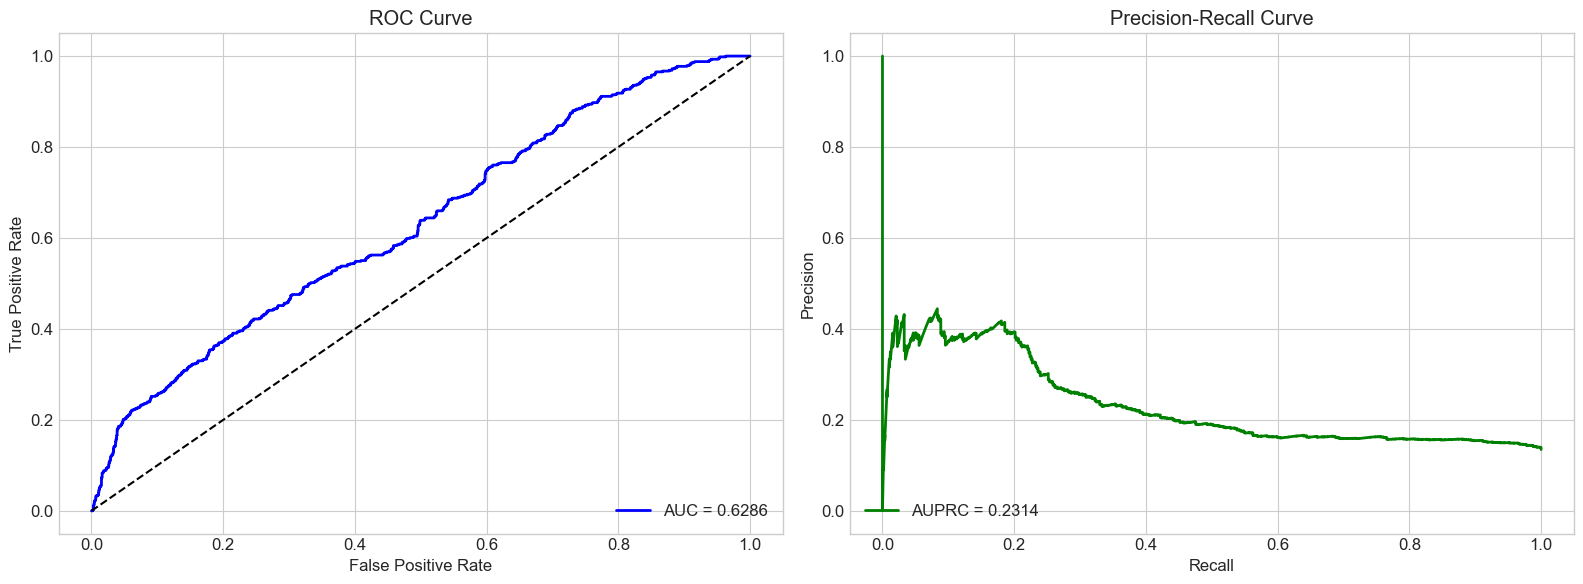

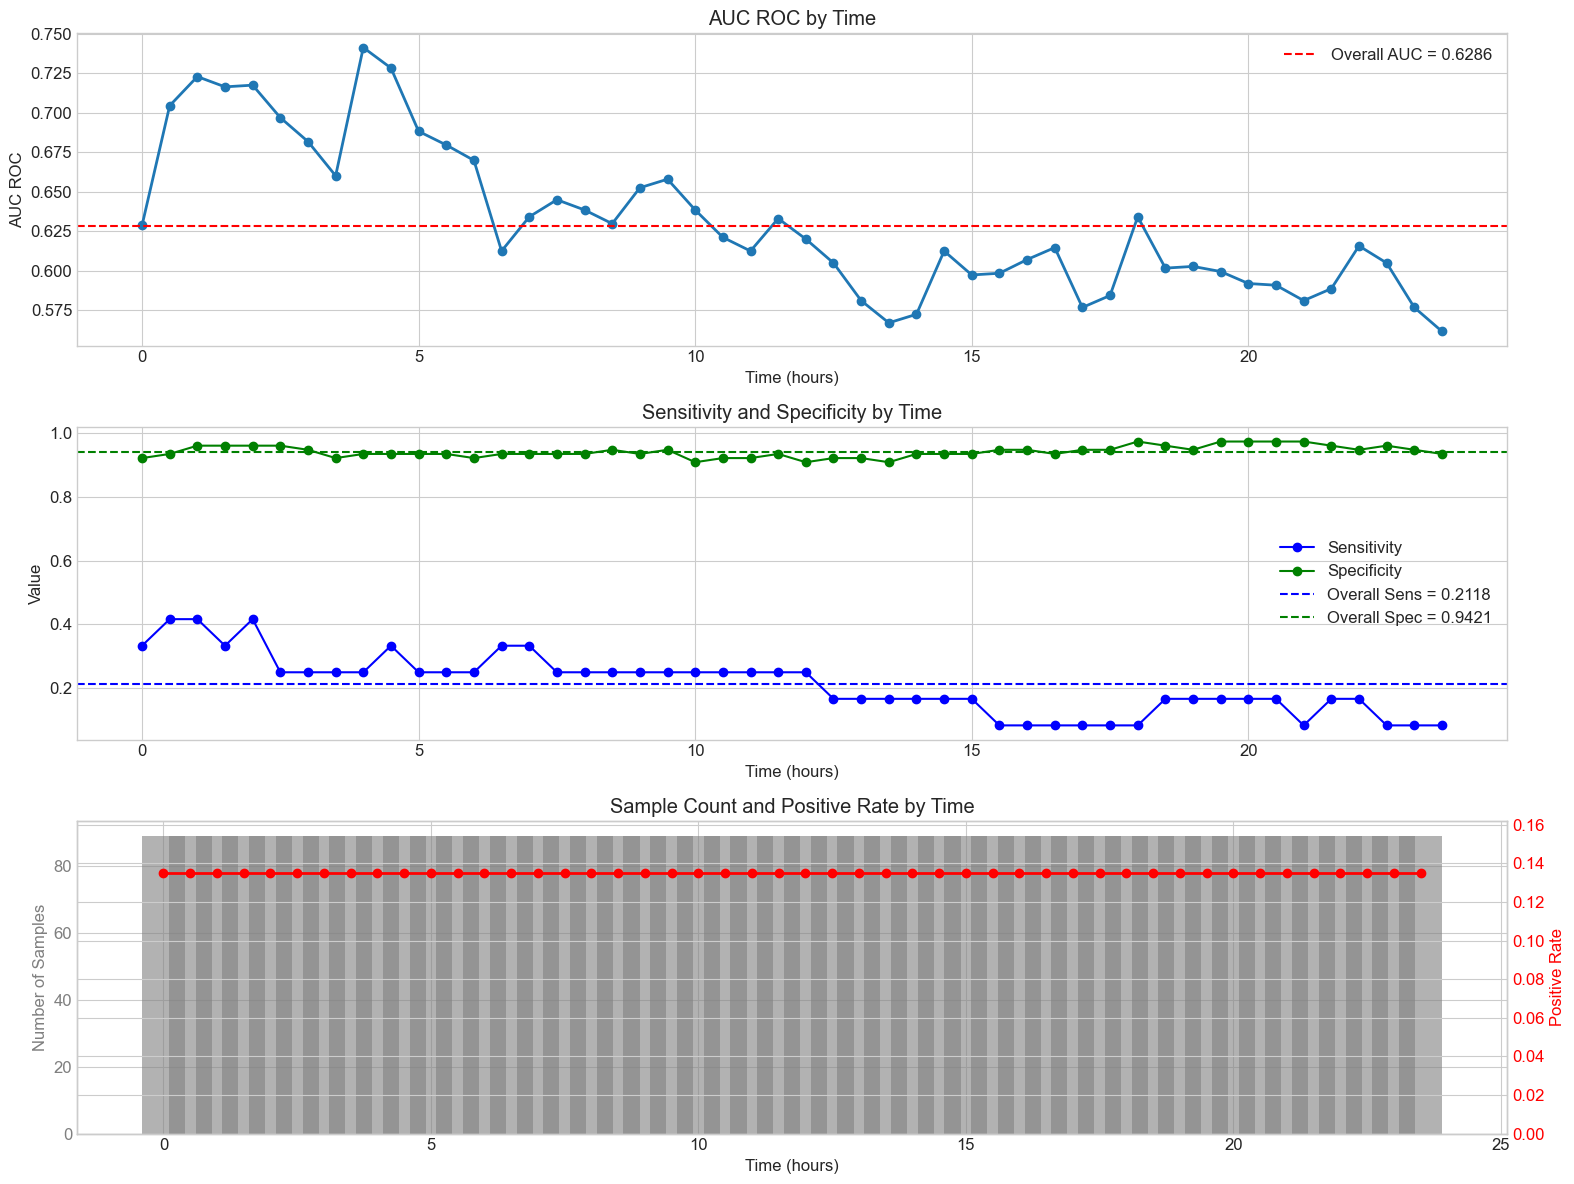

<Figure size 1200x1000 with 0 Axes>

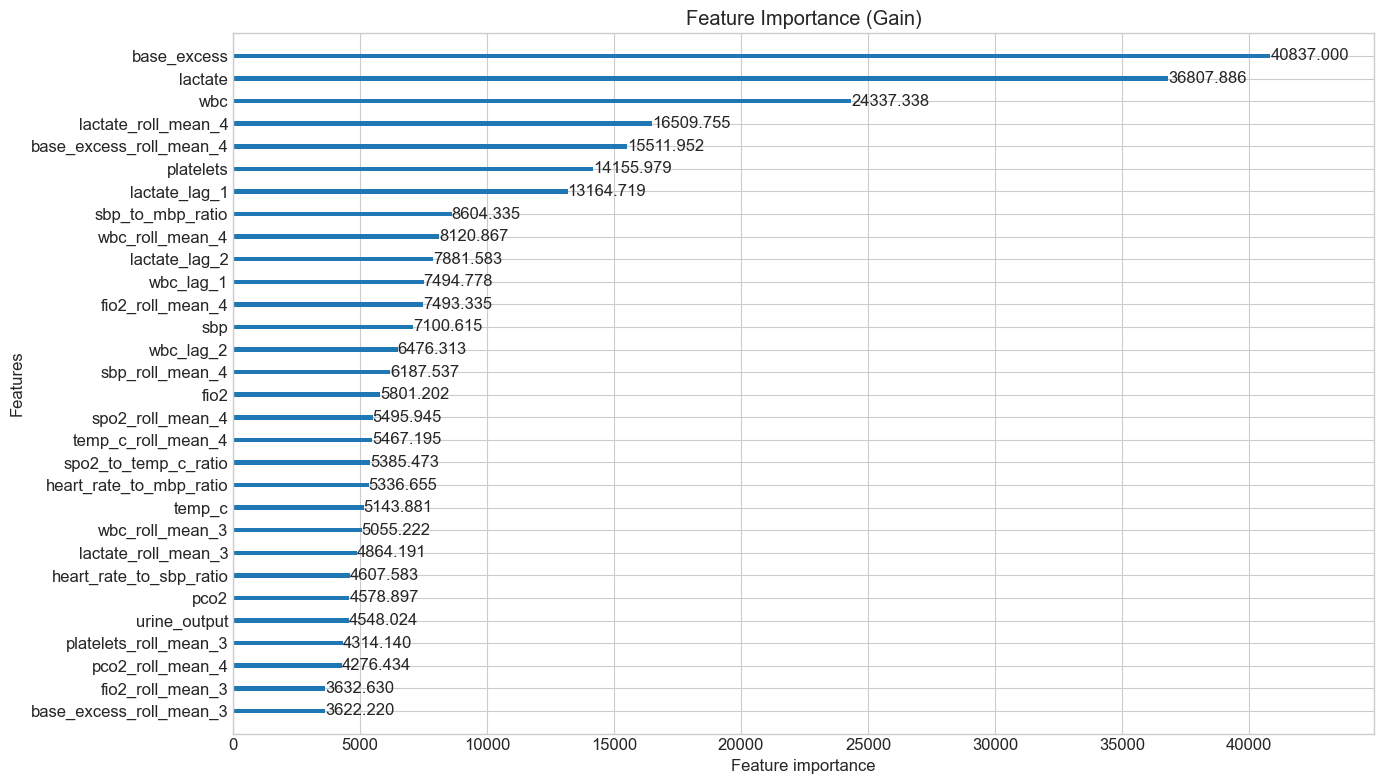

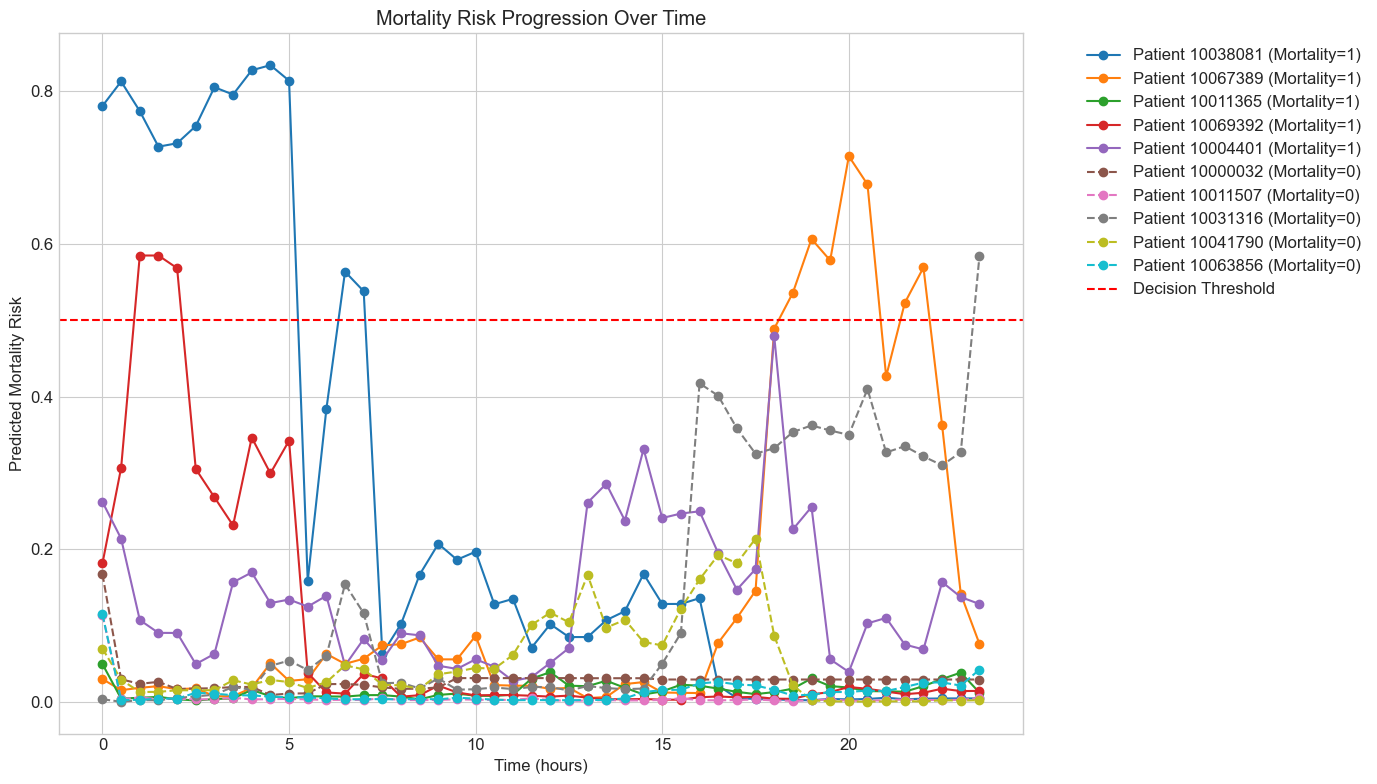

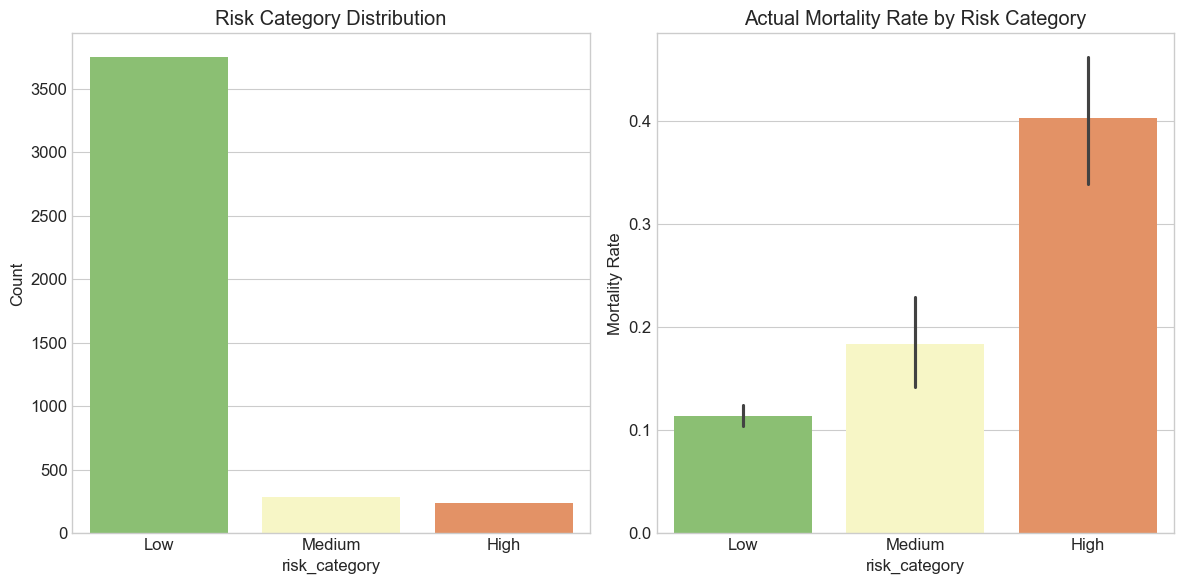

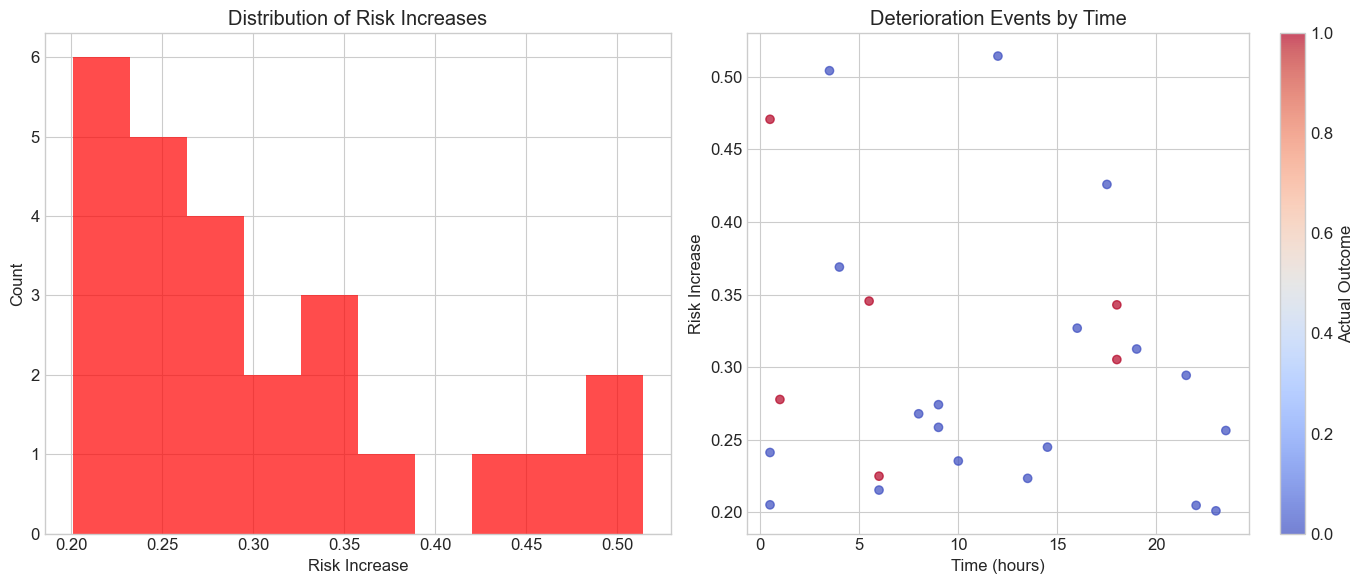

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                            precision_recall_curve, roc_curve, 
                            confusion_matrix, classification_report)
import re
import os
import warnings
import joblib
from datetime import datetime

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration
DATA_FILE = 'mimic_expanded_metrics_24hr.csv'
TARGET_COLUMN = 'icu_mortality'
PATIENT_ID_COLUMN = 'patient_id'
TEST_SIZE = 0.2
RANDOM_STATE = 42
OUTPUT_DIR = 'model_outputs'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Logging setup
def log_info(message):
    """Simple logging function"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[INFO] {timestamp} - {message}")

def log_warning(message):
    """Simple warning logging function"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[WARNING] {timestamp} - {message}")

def log_error(message):
    """Simple error logging function"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[ERROR] {timestamp} - {message}")

# Data loading and preprocessing functions
def load_data(filepath):
    """Load the dataset and do basic checks"""
    log_info(f"Loading data from {filepath}")
    
    try:
        df = pd.read_csv(filepath)
        log_info(f"Data loaded successfully. Shape: {df.shape}")
        
        # Check essential columns
        if PATIENT_ID_COLUMN not in df.columns:
            log_error(f"'{PATIENT_ID_COLUMN}' column not found in the dataset")
            return None
            
        if TARGET_COLUMN not in df.columns:
            log_error(f"'{TARGET_COLUMN}' column not found in the dataset")
            return None
            
        # Basic dataset statistics
        log_info(f"Number of unique patients: {df[PATIENT_ID_COLUMN].nunique()}")
        log_info(f"Target distribution: {df[TARGET_COLUMN].value_counts(normalize=True)}")
        
        return df
        
    except Exception as e:
        log_error(f"Error loading data: {str(e)}")
        return None

def extract_features_by_time(df):
    """
    Extract features and time steps from the dataset and organize them.
    This handles datasets where columns are in format 'feature_Xmin'.
    """
    log_info("Extracting features by time")
    
    # Initialize dictionaries to store information
    feature_data = {}
    time_points = set()
    
    # Regular expression to match 'feature_Xmin' pattern
    pattern = re.compile(r'(.+)_(\d+)min$')
    
    # Dictionary to organize columns by feature name
    features_dict = {}
    
    # Process each column
    for col in df.columns:
        if col == PATIENT_ID_COLUMN or col == TARGET_COLUMN:
            continue
            
        match = pattern.match(col)
        if match:
            feature_name, time_point = match.groups()
            time_point = int(time_point)
            
            # Add to time points set
            time_points.add(time_point)
            
            # Group columns by feature name
            if feature_name not in features_dict:
                features_dict[feature_name] = []
            
            features_dict[feature_name].append((col, time_point))
    
    # Sort time points
    sorted_time_points = sorted(time_points)
    log_info(f"Found {len(sorted_time_points)} time points: {sorted_time_points}")
    
    # Sort columns within each feature by time
    for feature, cols in features_dict.items():
        features_dict[feature] = sorted(cols, key=lambda x: x[1])
    
    log_info(f"Found {len(features_dict)} unique features")
    
    return features_dict, sorted_time_points

def prepare_patient_features(df, features_dict, time_points):
    """
    Prepare features for each patient at each time point.
    This creates a dataset suitable for time-series prediction.
    """
    log_info("Preparing patient features")
    
    records = []
    
    # Process each patient
    for patient_id, patient_data in df.groupby(PATIENT_ID_COLUMN):
        # Get the mortality outcome (same for all rows of this patient)
        mortality = patient_data[TARGET_COLUMN].iloc[0]
        
        # For each time point, create a record
        for time_point in time_points:
            record = {
                PATIENT_ID_COLUMN: patient_id,
                'time_step': time_point,
                TARGET_COLUMN: mortality
            }
            
            # Add feature values at this time point
            for feature, time_cols in features_dict.items():
                # Find the column for this time point if it exists
                col_name = None
                for col, t in time_cols:
                    if t == time_point:
                        col_name = col
                        break
                
                if col_name and col_name in patient_data.columns:
                    record[feature] = patient_data[col_name].iloc[0]
                else:
                    record[feature] = np.nan
            
            records.append(record)
    
    # Create DataFrame
    patient_df = pd.DataFrame(records)
    
    # Sort by patient and time
    patient_df.sort_values([PATIENT_ID_COLUMN, 'time_step'], inplace=True)
    
    log_info(f"Created patient features DataFrame with shape: {patient_df.shape}")
    
    return patient_df

def handle_missing_values(df):
    """
    Handle missing values in the dataset using multiple strategies.
    """
    log_info("Handling missing values")
    
    # Get feature columns (all except ID, target, and time_step)
    feature_cols = df.columns.difference([PATIENT_ID_COLUMN, TARGET_COLUMN, 'time_step'])
    
    # Check missing values before imputation
    missing_before = df[feature_cols].isnull().sum().sum()
    missing_pct = missing_before / (df.shape[0] * len(feature_cols)) * 100
    log_info(f"Missing values before imputation: {missing_before} ({missing_pct:.2f}%)")
    
    # Strategy 1: Forward fill within each patient group
    df[feature_cols] = df.groupby(PATIENT_ID_COLUMN)[feature_cols].ffill()
    
    # Strategy 2: Backward fill for initial values
    df[feature_cols] = df.groupby(PATIENT_ID_COLUMN)[feature_cols].bfill()
    
    # Check remaining missing values
    missing_after = df[feature_cols].isnull().sum().sum()
    
    if missing_after > 0:
        # Strategy 3: Fill remaining NaNs with median of that feature
        for col in feature_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].median())
    
    # Final check
    final_missing = df[feature_cols].isnull().sum().sum()
    log_info(f"Missing values after imputation: {final_missing}")
    
    return df

def engineer_features(df):
    """
    Engineer features for time-series prediction.
    """
    log_info("Engineering features")
    
    # Get feature columns (all except ID, target, and time_step)
    feature_cols = df.columns.difference([PATIENT_ID_COLUMN, TARGET_COLUMN, 'time_step'])
    
    # Group by patient
    grouped = df.groupby(PATIENT_ID_COLUMN)
    
    # List to track new columns
    new_cols = []
    
    # For each feature, create lagged and difference features
    for col in feature_cols:
        # Skip columns that are mostly NaN
        if df[col].isnull().mean() > 0.8:
            continue
            
        # Create lagged features (previous measurements)
        for lag in [1, 2]:
            lag_col = f"{col}_lag_{lag}"
            df[lag_col] = grouped[col].shift(lag)
            new_cols.append(lag_col)
        
        # Create difference features
        for diff in [1, 2]:
            diff_col = f"{col}_diff_{diff}"
            df[diff_col] = grouped[col].diff(diff)
            new_cols.append(diff_col)
        
        # Create rolling window features
        for window in [2, 3, 4]:
            # Rolling mean
            roll_mean_col = f"{col}_roll_mean_{window}"
            df[roll_mean_col] = grouped[col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
            )
            new_cols.append(roll_mean_col)
            
            # Rolling std
            roll_std_col = f"{col}_roll_std_{window}"
            df[roll_std_col] = grouped[col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
            )
            new_cols.append(roll_std_col)
    
    # Create interaction features for key vital signs
    vital_signs = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temp_c']
    vital_signs = [v for v in vital_signs if v in df.columns]
    
    if len(vital_signs) >= 2:
        for i in range(len(vital_signs)):
            for j in range(i+1, len(vital_signs)):
                col1 = vital_signs[i]
                col2 = vital_signs[j]
                ratio_col = f"{col1}_to_{col2}_ratio"
                df[ratio_col] = df[col1] / df[col2]
                df[ratio_col] = df[ratio_col].replace([np.inf, -np.inf], np.nan)
                new_cols.append(ratio_col)
    
    # Create clinical deterioration markers
    if 'heart_rate' in df.columns:
        df['tachycardia'] = (df['heart_rate'] > 100).astype(int)
        df['bradycardia'] = (df['heart_rate'] < 60).astype(int)
        new_cols.extend(['tachycardia', 'bradycardia'])
    
    if 'sbp' in df.columns:
        df['hypotension'] = (df['sbp'] < 90).astype(int)
        new_cols.append('hypotension')
    
    if 'resp_rate' in df.columns:
        df['tachypnea'] = (df['resp_rate'] > 20).astype(int)
        new_cols.append('tachypnea')
    
    if 'spo2' in df.columns:
        df['hypoxemia'] = (df['spo2'] < 92).astype(int)
        new_cols.append('hypoxemia')
    
    # Add time-based features
    df['time_step_hours'] = df['time_step'] / 60
    new_cols.append('time_step_hours')
    
    # Fill missing values in new columns
    for col in new_cols:
        if col.endswith('_std'):
            # Fill std with 0 (no variation for single points)
            df[col] = df[col].fillna(0)
        else:
            # Fill others with median
            df[col] = df[col].fillna(df[col].median())
    
    log_info(f"Created {len(new_cols)} new features")
    
    return df

def split_dataset(df):
    """
    Split the dataset into training and testing sets,
    ensuring no patient appears in both sets.
    """
    log_info("Splitting dataset")
    
    # Use GroupShuffleSplit to keep patients together
    splitter = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    # Get train and test indices
    train_idx, test_idx = next(splitter.split(df, groups=df[PATIENT_ID_COLUMN]))
    
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df = df.iloc[test_idx].reset_index(drop=True)
    
    # Verify no patient appears in both sets
    train_patients = set(train_df[PATIENT_ID_COLUMN].unique())
    test_patients = set(test_df[PATIENT_ID_COLUMN].unique())
    overlap = train_patients.intersection(test_patients)
    
    if len(overlap) > 0:
        log_warning(f"Found {len(overlap)} patients in both train and test sets")
    else:
        log_info("No patients overlap between train and test sets")
    
    # Features and targets
    feature_cols = df.columns.difference([PATIENT_ID_COLUMN, TARGET_COLUMN, 'time_step'])
    X_train = train_df[feature_cols]
    y_train = train_df[TARGET_COLUMN]
    X_test = test_df[feature_cols]
    y_test = test_df[TARGET_COLUMN]
    
    log_info(f"Train set: {X_train.shape[0]} samples, {len(train_patients)} patients")
    log_info(f"Test set: {X_test.shape[0]} samples, {len(test_patients)} patients")
    log_info(f"Train positive rate: {y_train.mean():.4f}")
    log_info(f"Test positive rate: {y_test.mean():.4f}")
    
    return X_train, X_test, y_train, y_test, train_df, test_df

def train_model(X_train, y_train, X_val, y_val):
    """
    Train a LightGBM model with early stopping.
    """
    log_info("Training LightGBM model")
    
    # Calculate class weight for imbalanced data
    pos_weight = (len(y_train) - y_train.sum()) / y_train.sum() if y_train.sum() > 0 else 1
    
    # Initialize model
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scale_pos_weight=pos_weight
    )
    
    # Train with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
    )
    
    log_info(f"Model training complete. Best iteration: {model.best_iteration_}")
    
    return model

def evaluate_model(model, X_test, y_test, test_df):
    """
    Evaluate the model and produce performance metrics and visualizations.
    """
    log_info("Evaluating model")
    
    # Generate predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Add predictions to test_df
    test_results = test_df.copy()
    test_results['prediction_probability'] = y_pred_proba
    test_results['prediction'] = y_pred
    
    # Calculate overall metrics
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_prc = average_precision_score(y_test, y_pred_proba)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Additional metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Log overall metrics
    log_info(f"AUC ROC: {auc_roc:.4f}")
    log_info(f"AUC PRC: {auc_prc:.4f}")
    log_info(f"Accuracy: {accuracy:.4f}")
    log_info(f"Sensitivity: {sensitivity:.4f}")
    log_info(f"Specificity: {specificity:.4f}")
    log_info(f"PPV: {ppv:.4f}")
    log_info(f"NPV: {npv:.4f}")
    
    # Classification report
    class_report = classification_report(y_test, y_pred)
    log_info(f"Classification Report:\n{class_report}")
    
    # Calculate metrics by time step
    time_metrics = []
    unique_time_steps = sorted(test_results['time_step'].unique())
    
    for t in unique_time_steps:
        subset = test_results[test_results['time_step'] == t]
        if len(subset) > 10 and len(subset[TARGET_COLUMN].unique()) > 1:
            try:
                t_auc = roc_auc_score(subset[TARGET_COLUMN], subset['prediction_probability'])
                t_auprc = average_precision_score(subset[TARGET_COLUMN], subset['prediction_probability'])
                
                # Confusion matrix for this time step
                t_conf = confusion_matrix(subset[TARGET_COLUMN], subset['prediction'])
                t_tn, t_fp, t_fn, t_tp = t_conf.ravel()
                
                # Calculate additional metrics
                t_sens = t_tp / (t_tp + t_fn) if (t_tp + t_fn) > 0 else 0
                t_spec = t_tn / (t_tn + t_fp) if (t_tn + t_fp) > 0 else 0
                
                time_metrics.append({
                    'time_step': t,
                    'time_hours': t/60,
                    'auc': t_auc,
                    'auprc': t_auprc,
                    'sensitivity': t_sens,
                    'specificity': t_spec,
                    'n_samples': len(subset),
                    'positive_rate': subset[TARGET_COLUMN].mean()
                })
            except Exception as e:
                log_warning(f"Error calculating metrics for time step {t}: {str(e)}")
    
    time_metrics_df = pd.DataFrame(time_metrics)
    
    # Plot ROC and PR curves
    plt.figure(figsize=(16, 6))
    
    # ROC curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_roc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # PR curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, 'g-', linewidth=2, label=f'AUPRC = {auc_prc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/roc_pr_curves.png", dpi=300)
    
    # Plot metrics by time step if we have data
    if not time_metrics_df.empty:
        plt.figure(figsize=(16, 12))
        
        # AUC ROC vs Time
        plt.subplot(3, 1, 1)
        plt.plot(time_metrics_df['time_hours'], time_metrics_df['auc'], 'o-', linewidth=2)
        plt.axhline(y=auc_roc, color='r', linestyle='--', label=f'Overall AUC = {auc_roc:.4f}')
        plt.xlabel('Time (hours)')
        plt.ylabel('AUC ROC')
        plt.title('AUC ROC by Time')
        plt.legend()
        plt.grid(True)
        
        # Sensitivity and Specificity vs Time
        plt.subplot(3, 1, 2)
        plt.plot(time_metrics_df['time_hours'], time_metrics_df['sensitivity'], 'o-', color='blue', label='Sensitivity')
        plt.plot(time_metrics_df['time_hours'], time_metrics_df['specificity'], 'o-', color='green', label='Specificity')
        plt.axhline(y=sensitivity, color='blue', linestyle='--', label=f'Overall Sens = {sensitivity:.4f}')
        plt.axhline(y=specificity, color='green', linestyle='--', label=f'Overall Spec = {specificity:.4f}')
        plt.xlabel('Time (hours)')
        plt.ylabel('Value')
        plt.title('Sensitivity and Specificity by Time')
        plt.legend()
        plt.grid(True)
        
        # Sample Count and Positive Rate vs Time
        plt.subplot(3, 1, 3)
        ax1 = plt.gca()
        ax1.bar(time_metrics_df['time_hours'], time_metrics_df['n_samples'], color='gray', alpha=0.6)
        ax1.set_xlabel('Time (hours)')
        ax1.set_ylabel('Number of Samples', color='gray')
        ax1.tick_params(axis='y', colors='gray')
        
        ax2 = ax1.twinx()
        ax2.plot(time_metrics_df['time_hours'], time_metrics_df['positive_rate'], 'ro-', linewidth=2)
        ax2.set_ylabel('Positive Rate', color='red')
        ax2.tick_params(axis='y', colors='red')
        ax2.set_ylim([0, max(time_metrics_df['positive_rate'])*1.2])
        
        plt.title('Sample Count and Positive Rate by Time')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/time_metrics.png", dpi=300)
    
    # Feature importance
    plt.figure(figsize=(12, 10))
    lgb.plot_importance(model, max_num_features=30, importance_type='gain')
    plt.title('Feature Importance (Gain)')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/feature_importance.png", dpi=300)
    
    # Return metrics and results
    return test_results, time_metrics_df, {
        'auc_roc': auc_roc,
        'auc_prc': auc_prc,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv
    }

def predict_risk_progression(model, test_df, feature_cols):
    """
    Predict how risk changes over the ICU stay for individual patients.
    Create visualizations showing risk trajectories.
    """
    log_info("Analyzing risk progression")
    
    # Get a subset of test patients to visualize
    mortality_patients = test_df[test_df[TARGET_COLUMN] == 1][PATIENT_ID_COLUMN].unique()
    survival_patients = test_df[test_df[TARGET_COLUMN] == 0][PATIENT_ID_COLUMN].unique()
    
    # Select up to 5 patients from each group
    mortality_sample = np.random.choice(mortality_patients, size=min(5, len(mortality_patients)), replace=False)
    survival_sample = np.random.choice(survival_patients, size=min(5, len(survival_patients)), replace=False)
    
    sample_patients = np.concatenate([mortality_sample, survival_sample])
    
    # Prepare visualization
    plt.figure(figsize=(14, 8))
    
    # Plot risk trajectories
    for patient_id in sample_patients:
        patient_data = test_df[test_df[PATIENT_ID_COLUMN] == patient_id].sort_values('time_step')
        
        # Check if we have predictions for this patient
        if 'prediction_probability' not in patient_data.columns:
            # Make predictions
            patient_X = patient_data[feature_cols]
            patient_probs = model.predict_proba(patient_X)[:, 1]
            patient_data['prediction_probability'] = patient_probs
        
        # Plot
        time_hours = patient_data['time_step'] / 60
        mortality = patient_data[TARGET_COLUMN].iloc[0]
        linestyle = '-' if mortality == 1 else '--'
        plt.plot(time_hours, patient_data['prediction_probability'], 
                 marker='o', linestyle=linestyle,
                 label=f"Patient {patient_id} (Mortality={mortality})")
    
    plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold')
    plt.xlabel('Time (hours)')
    plt.ylabel('Predicted Mortality Risk')
    plt.title('Mortality Risk Progression Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/risk_progression.png", dpi=300)
    
    return sample_patients

def identify_risk_factors(model, X_train, feature_names):
    """
    Identify key risk factors that contribute to mortality prediction.
    """
    log_info("Identifying key risk factors")
    
    # Get feature importance
    importance = model.feature_importances_
    
    # Create DataFrame of feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Save to CSV
    feature_importance.to_csv(f"{OUTPUT_DIR}/feature_importance.csv", index=False)
    
    # Print top features
    top_features = feature_importance.head(20)
    log_info("Top 20 features:")
    for i, (feature, importance) in enumerate(zip(top_features['Feature'], top_features['Importance'])):
        log_info(f"{i+1}. {feature}: {importance:.6f}")
    
    return feature_importance

def create_early_warning_system(test_results):
    """
    Create an early warning system that identifies patients at high risk.
    """
    log_info("Creating early warning system")
    
    # Define risk thresholds
    HIGH_RISK_THRESHOLD = 0.7
    MEDIUM_RISK_THRESHOLD = 0.3
    
    # Add risk category
    test_results['risk_category'] = pd.cut(
        test_results['prediction_probability'],
        bins=[0, MEDIUM_RISK_THRESHOLD, HIGH_RISK_THRESHOLD, 1],
        labels=['Low', 'Medium', 'High']
    )
    
    # Calculate actual mortality rates by risk category
    risk_outcomes = test_results.groupby('risk_category')[TARGET_COLUMN].agg(['mean', 'count'])
    risk_outcomes.columns = ['Mortality Rate', 'Count']
    
    log_info("Risk category outcomes:")
    log_info(risk_outcomes)
    
    # Plot distribution of risk categories
    plt.figure(figsize=(12, 6))
    
    # Risk distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x='risk_category', data=test_results, palette='RdYlGn_r')
    plt.title('Risk Category Distribution')
    plt.ylabel('Count')
    
    # Mortality by risk category
    plt.subplot(1, 2, 2)
    sns.barplot(x='risk_category', y=TARGET_COLUMN, data=test_results, palette='RdYlGn_r')
    plt.title('Actual Mortality Rate by Risk Category')
    plt.ylabel('Mortality Rate')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/risk_categories.png", dpi=300)
    
    # Identify patients with significant deterioration
    # (large increase in risk between consecutive time points)
    deterioration_threshold = 0.2  # 20% absolute increase in risk
    
    deterioration_events = []
    
    for patient_id in test_results[PATIENT_ID_COLUMN].unique():
        patient_data = test_results[test_results[PATIENT_ID_COLUMN] == patient_id].sort_values('time_step')
        
        if len(patient_data) < 2:
            continue
        
        # Calculate risk increase between consecutive time points
        patient_data['risk_change'] = patient_data['prediction_probability'].diff()
        
        # Find significant deterioration events
        deterioration = patient_data[patient_data['risk_change'] >= deterioration_threshold]
        
        for _, row in deterioration.iterrows():
            deterioration_events.append({
                'patient_id': patient_id,
                'time_step': row['time_step'],
                'time_hours': row['time_step'] / 60,
                'previous_risk': row['prediction_probability'] - row['risk_change'],
                'current_risk': row['prediction_probability'],
                'risk_increase': row['risk_change'],
                'actual_outcome': row[TARGET_COLUMN]
            })
    
    # Create DataFrame of deterioration events
    deterioration_df = pd.DataFrame(deterioration_events)
    
    if not deterioration_df.empty:
        log_info(f"Found {len(deterioration_df)} significant deterioration events")
        log_info(f"Average risk increase: {deterioration_df['risk_increase'].mean():.4f}")
        
        # Save to CSV
        deterioration_df.to_csv(f"{OUTPUT_DIR}/deterioration_events.csv", index=False)
        
        # Plot deterioration events
        plt.figure(figsize=(14, 6))
        
        # Distribution of risk increases
        plt.subplot(1, 2, 1)
        plt.hist(deterioration_df['risk_increase'], bins=10, color='red', alpha=0.7)
        plt.xlabel('Risk Increase')
        plt.ylabel('Count')
        plt.title('Distribution of Risk Increases')
        
        # Deterioration events by time
        plt.subplot(1, 2, 2)
        plt.scatter(deterioration_df['time_hours'], deterioration_df['risk_increase'], 
                   c=deterioration_df['actual_outcome'], cmap='coolwarm', alpha=0.7)
        plt.xlabel('Time (hours)')
        plt.ylabel('Risk Increase')
        plt.title('Deterioration Events by Time')
        plt.colorbar(label='Actual Outcome')
        
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/deterioration_events.png", dpi=300)
    else:
        log_info("No significant deterioration events found")
    
    return test_results, deterioration_df if not deterioration_df.empty else None

def save_model_and_results(model, feature_names, results, metrics):
    """
    Save the trained model, features, and results.
    """
    log_info("Saving model and results")
    
    # Save model
    model_file = f"{OUTPUT_DIR}/icu_mortality_model.pkl"
    joblib.dump(model, model_file)
    
    # Save feature names
    with open(f"{OUTPUT_DIR}/feature_names.txt", 'w') as f:
        f.write('\n'.join(feature_names))
    
    # Save results
    results.to_csv(f"{OUTPUT_DIR}/test_predictions.csv", index=False)
    
    # Save metrics
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(f"{OUTPUT_DIR}/model_metrics.csv", index=False)
    
    log_info(f"Model saved to {model_file}")
    log_info(f"All results saved to {OUTPUT_DIR}/")

def main():
    """Main execution function"""
    log_info("Starting ICU mortality prediction pipeline")
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Load data
    df = load_data(DATA_FILE)
    if df is None:
        log_error("Failed to load data")
        return
    
    # Extract features by time
    features_dict, time_points = extract_features_by_time(df)
    
    # Prepare patient features
    patient_df = prepare_patient_features(df, features_dict, time_points)
    
    # Handle missing values
    imputed_df = handle_missing_values(patient_df)
    
    # Engineer features
    featured_df = engineer_features(imputed_df)
    
    # Split dataset
    X_train, X_test, y_train, y_test, train_df, test_df = split_dataset(featured_df)
    
    # Get feature columns
    feature_cols = X_train.columns
    
    # Train model
    model = train_model(X_train, y_train, X_test, y_test)
    
    # Evaluate model
    results, time_metrics, overall_metrics = evaluate_model(model, X_test, y_test, test_df)
    
    # Predict risk progression
    sample_patients = predict_risk_progression(model, results, feature_cols)
    
    # Identify risk factors
    feature_importance = identify_risk_factors(model, X_train, feature_cols)
    
    # Create early warning system
    risk_results, deterioration_events = create_early_warning_system(results)
    
    # Save model and results
    save_model_and_results(model, feature_cols, risk_results, overall_metrics)
    
    log_info("ICU mortality prediction pipeline complete")

if __name__ == "__main__":
    main()

Starting Shapley value analysis
Loaded model from model_outputs/icu_mortality_model.pkl
[INFO] 2025-04-27 10:16:25 - Loading data from mimic_expanded_metrics_24hr.csv
[INFO] 2025-04-27 10:16:25 - Data loaded successfully. Shape: (444, 722)
[INFO] 2025-04-27 10:16:25 - Number of unique patients: 444
[INFO] 2025-04-27 10:16:25 - Target distribution: icu_mortality
0    0.876126
1    0.123874
Name: proportion, dtype: float64
[INFO] 2025-04-27 10:16:25 - Extracting features by time
[INFO] 2025-04-27 10:16:25 - Found 48 time points: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410]
[INFO] 2025-04-27 10:16:25 - Found 15 unique features
[INFO] 2025-04-27 10:16:25 - Preparing patient features
[INFO] 2025-04-27 10:16:30 - Created patient features DataFrame with shape: (21312, 18)
[INFO] 2025-04-27 1

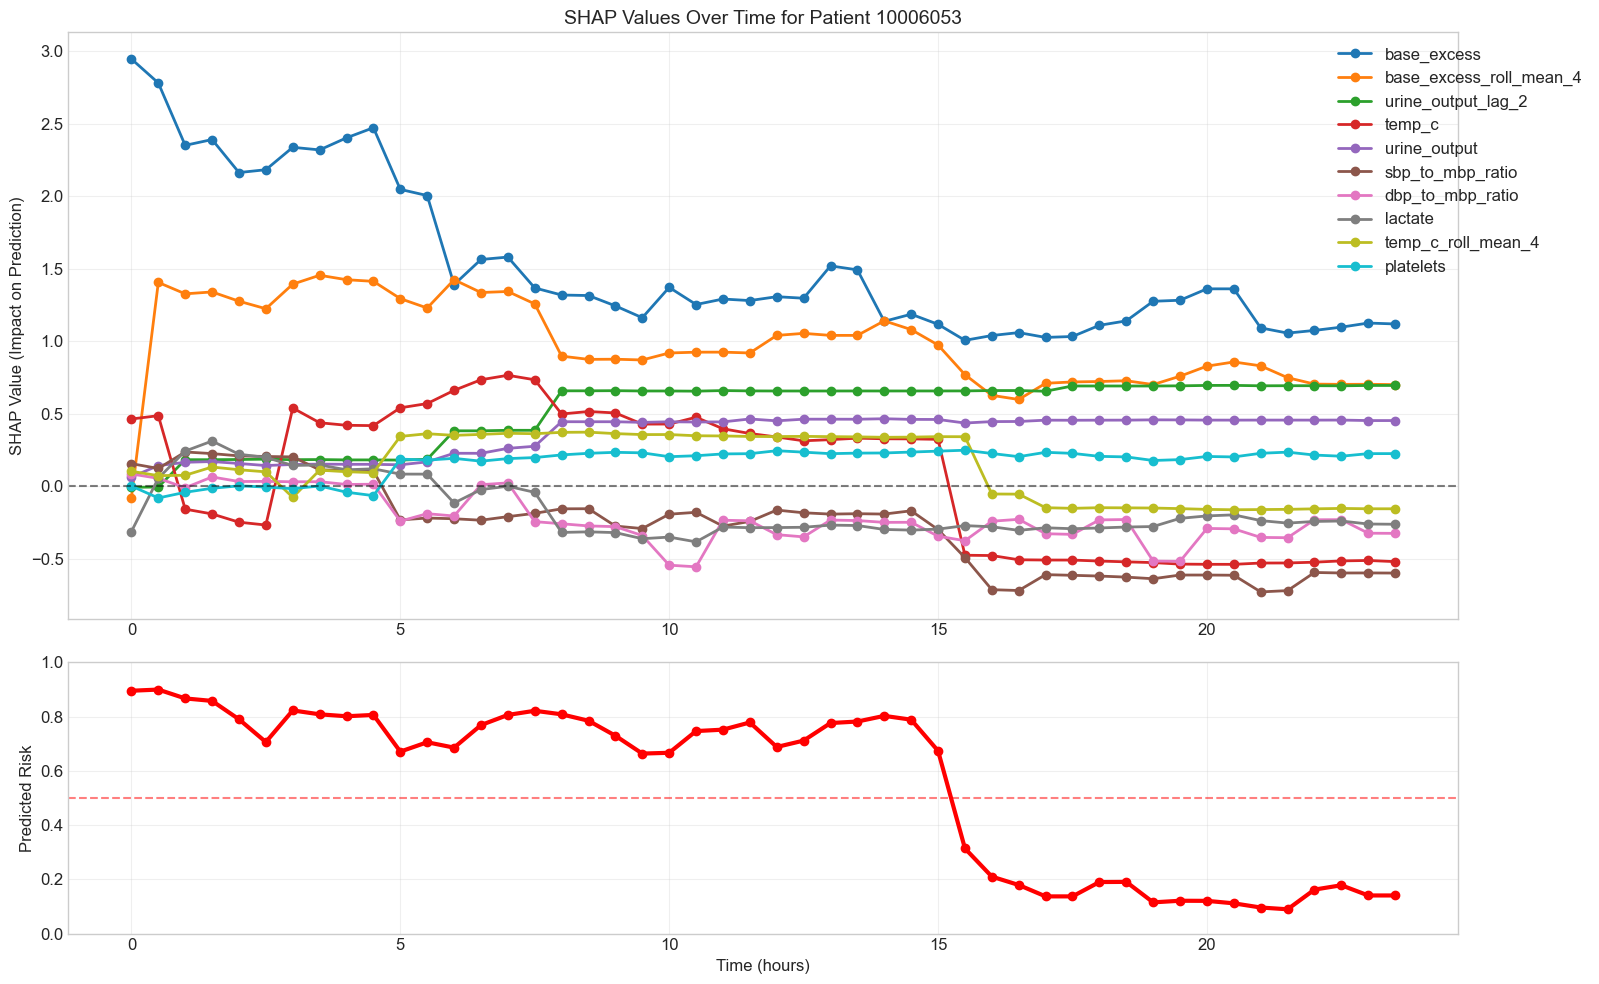

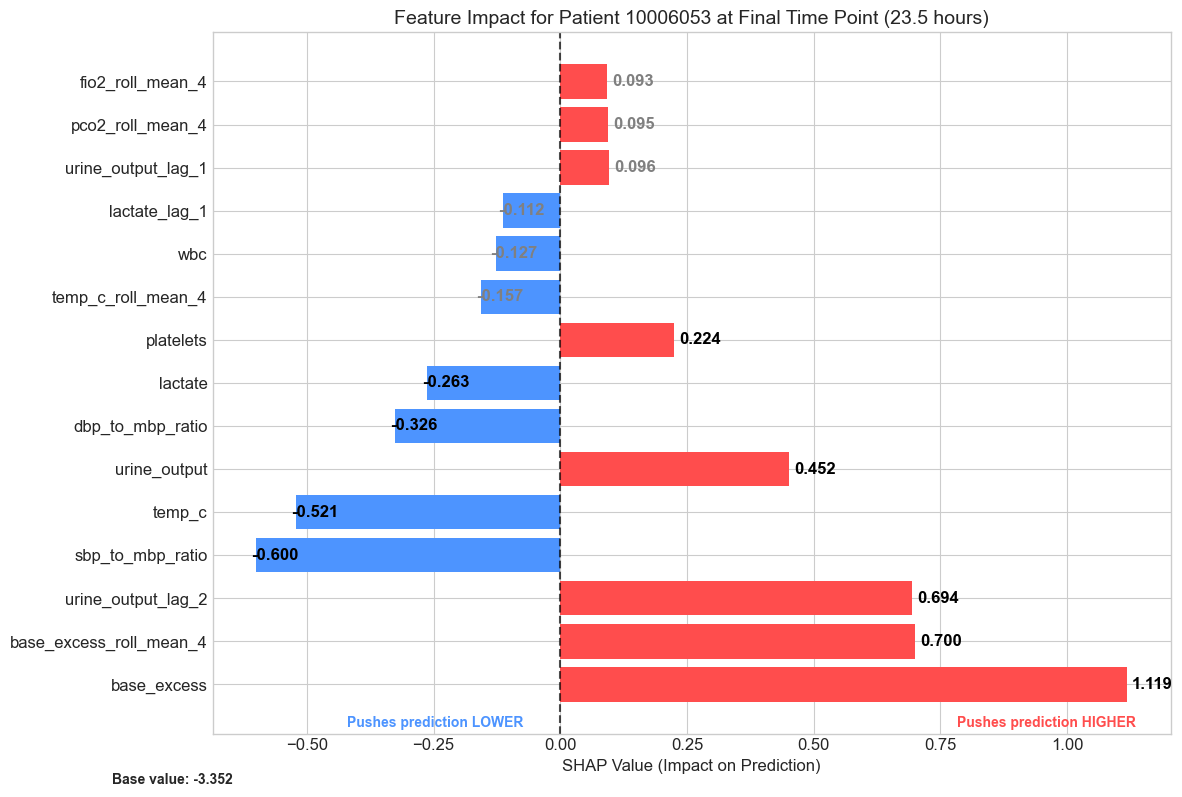

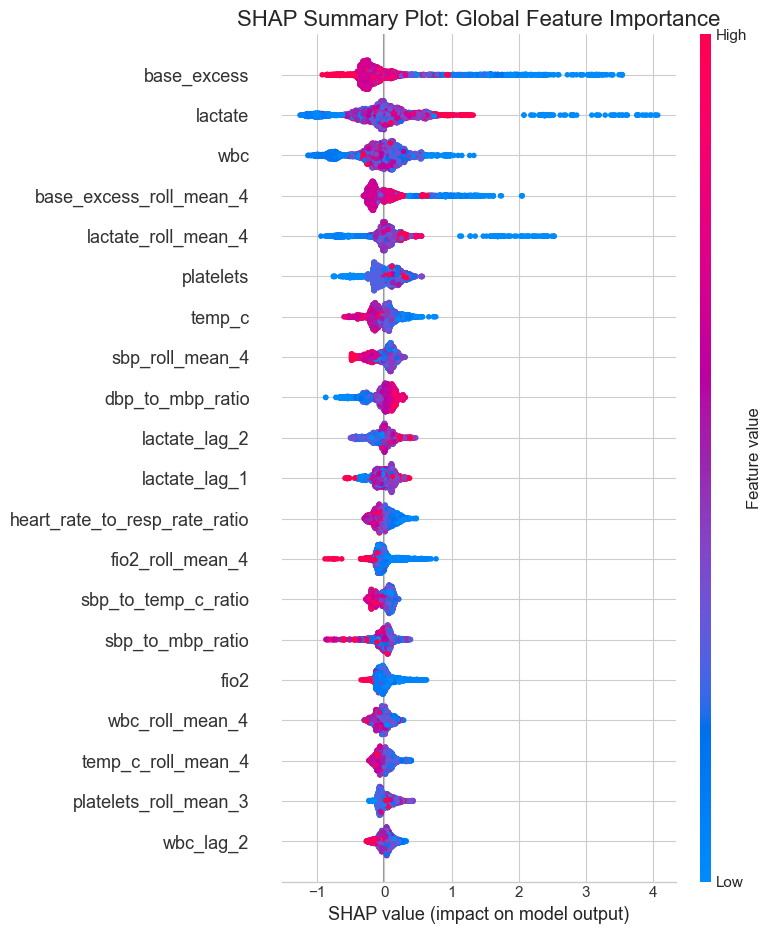

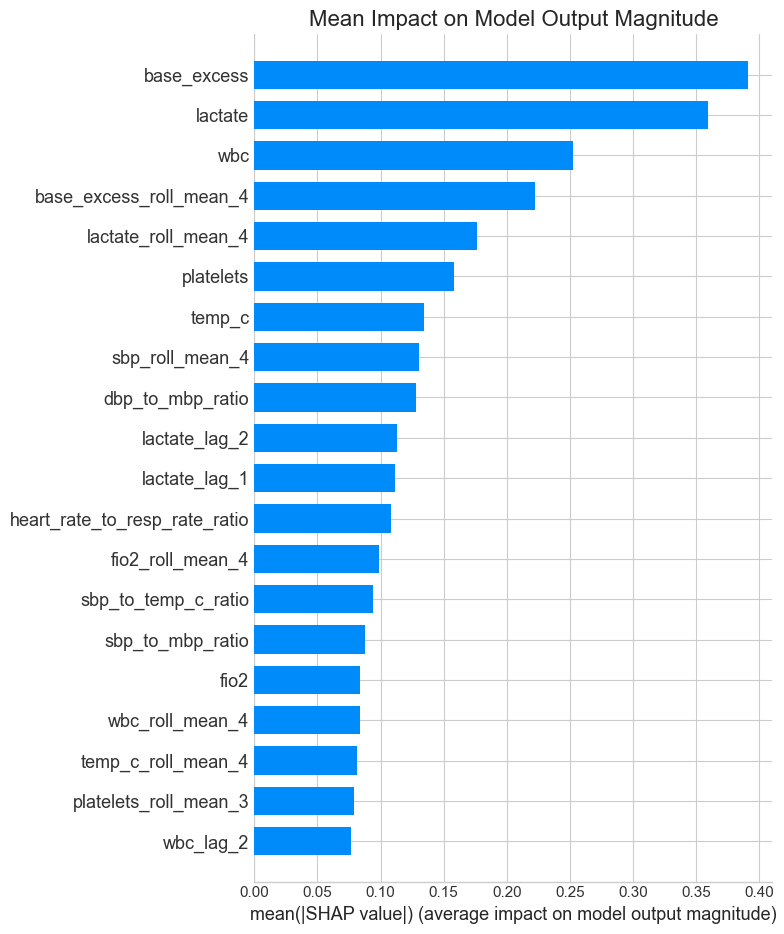

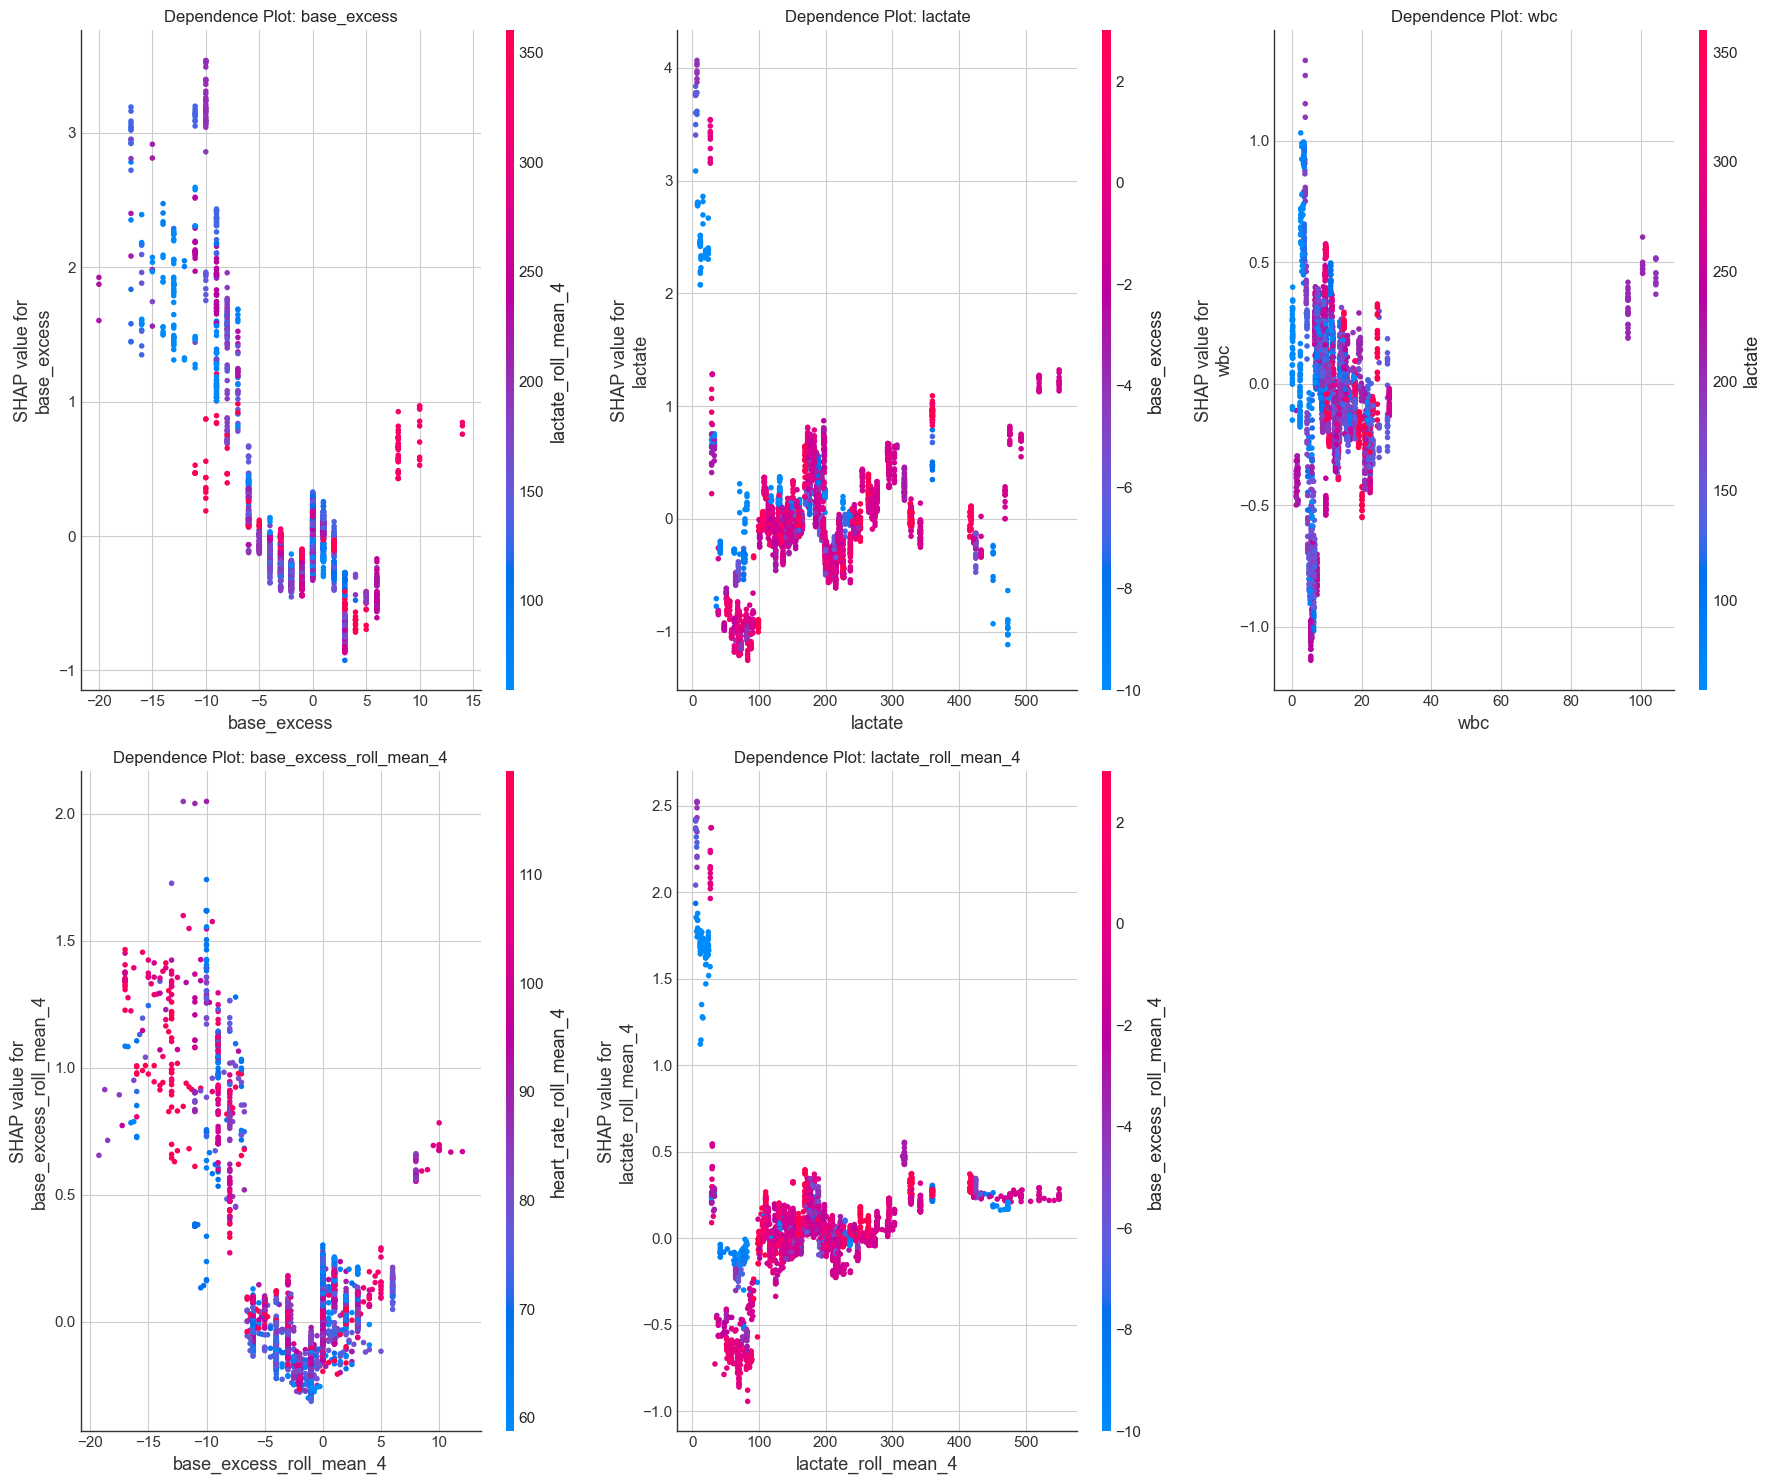

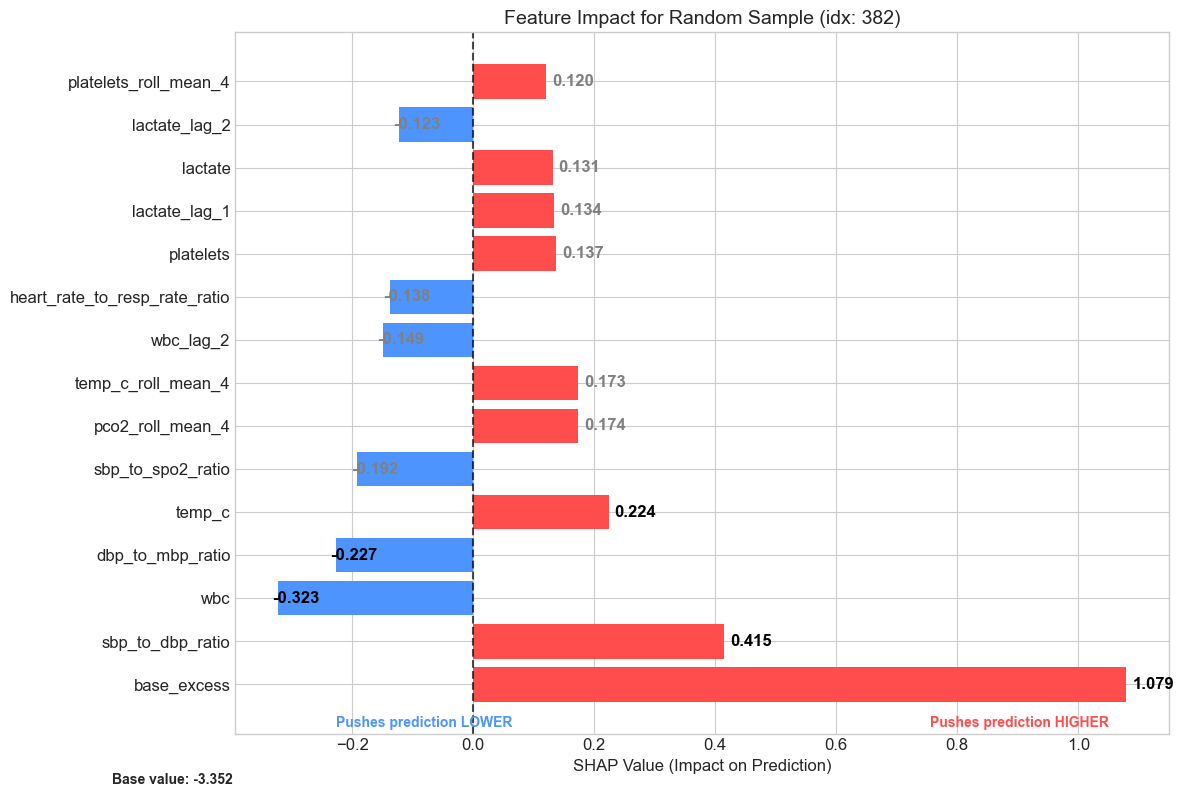

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from scipy import stats
import warnings
import os
from sklearn.preprocessing import StandardScaler

# Suppress warnings
warnings.filterwarnings('ignore')

def patient_shapley_over_time_fixed(model, test_df, patient_id=None):
    """
    Analyze and visualize how SHAP values change over time for a specific patient
    
    Parameters:
    - model: Trained LightGBM model
    - test_df: DataFrame containing test data with timestamps
    - patient_id: ID of the patient to analyze (if None, will choose a random patient)
    
    Returns:
    - Patient SHAP DataFrame
    """
    # If no patient_id provided, select one
    if patient_id is None:
        # Prefer a patient with mortality=1 and sufficient time points
        mortality_patients = test_df[test_df[TARGET_COLUMN] == 1][PATIENT_ID_COLUMN].unique()
        
        if len(mortality_patients) > 0:
            # Get counts of records for each patient
            patient_counts = test_df[test_df[PATIENT_ID_COLUMN].isin(mortality_patients)].groupby(PATIENT_ID_COLUMN).size()
            # Filter patients with at least 5 time points
            eligible_patients = patient_counts[patient_counts >= 5].index.tolist()
            
            if eligible_patients:
                patient_id = np.random.choice(eligible_patients)
            else:
                patient_id = np.random.choice(mortality_patients)
        else:
            # Get a random patient
            patient_id = np.random.choice(test_df[PATIENT_ID_COLUMN].unique())
    
    print(f"Analyzing Shapley values over time for patient {patient_id}")
    
    # Get patient data
    patient_data = test_df[test_df[PATIENT_ID_COLUMN] == patient_id].sort_values('time_step')
    
    if len(patient_data) < 2:
        print(f"Patient {patient_id} has too few time points ({len(patient_data)})")
        return None
    
    # Get feature columns
    feature_cols = patient_data.columns.difference([PATIENT_ID_COLUMN, TARGET_COLUMN, 'time_step', 
                                                 'prediction_probability', 'prediction',
                                                 'risk_category', 'risk_change'])
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Generate predictions if they don't exist
    if 'prediction_probability' not in patient_data.columns:
        patient_X = patient_data[feature_cols]
        patient_probs = model.predict_proba(patient_X)[:, 1]
        patient_data['prediction_probability'] = patient_probs
    
    # Calculate SHAP values for each time point
    shap_values_by_time = []
    time_points = []
    
    for idx, row in patient_data.iterrows():
        # Get feature values
        X = row[feature_cols].values.reshape(1, -1)
        
        # Calculate SHAP values
        try:
            # Try using the legacy method first for backward compatibility
            shap_values = explainer.shap_values(X)
            
            # For multi-class problems, take class 1 values
            if isinstance(shap_values, list):
                shap_values = shap_values[1]
                
            # Extract the values from the first row
            if len(shap_values.shape) > 1 and shap_values.shape[0] == 1:
                values = shap_values[0]
            else:
                values = shap_values
        except:
            # If that fails, try the newer method
            try:
                explanation = explainer(X)
                values = explanation.values[0] if explanation.values.shape[0] == 1 else explanation.values
            except:
                # Last resort - just use zeros as a placeholder
                print(f"Warning: Could not calculate SHAP values for patient {patient_id} at time {row['time_step']}")
                values = np.zeros(len(feature_cols))
        
        shap_values_by_time.append(values)
        time_points.append(row['time_step'])
    
    # Create DataFrame with SHAP values
    shap_df = pd.DataFrame(shap_values_by_time, columns=feature_cols)
    shap_df['time_step'] = time_points
    shap_df['time_hours'] = shap_df['time_step'] / 60
    
    # Add actual metrics and predictions
    for col in ['prediction_probability', TARGET_COLUMN]:
        if col in patient_data.columns:
            shap_df[col] = patient_data[col].values
    
    # Identify top 10 most influential features (based on absolute SHAP values)
    mean_abs_shap = np.abs(shap_df[feature_cols]).mean().sort_values(ascending=False)
    top_features = mean_abs_shap.head(10).index.tolist()
    
    # Create visualization of SHAP values over time
    plt.figure(figsize=(16, 10))
    
    # Create main plot
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    
    # For each top feature, plot its SHAP value over time
    for feature in top_features:
        ax1.plot(
            shap_df['time_hours'], 
            shap_df[feature], 
            marker='o', 
            linewidth=2, 
            label=feature
        )
    
    # Add zero line
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Set labels and title
    ax1.set_title(f'SHAP Values Over Time for Patient {patient_id}', fontsize=14)
    ax1.set_ylabel('SHAP Value (Impact on Prediction)', fontsize=12)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax1.grid(True, alpha=0.3)
    
    # Create risk plot on a separate subplot
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    # Plot risk scores
    ax2.plot(
        shap_df['time_hours'], 
        shap_df['prediction_probability'], 
        'ro-', 
        linewidth=3,
        label='Mortality Risk'
    )
    
    # Add threshold line
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    
    # Set labels
    ax2.set_xlabel('Time (hours)', fontsize=12)
    ax2.set_ylabel('Predicted Risk', fontsize=12)
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/patient_{patient_id}_shap_timeline.png", dpi=300)
    
    # For the waterfall plot, create a manual bar chart visualization
    # Get the last row of patient data
    last_row = patient_data.iloc[-1]
    last_time_hour = last_row['time_step'] / 60
    
    # Extract the SHAP values for this time point
    last_shap_values = shap_df.iloc[-1][feature_cols]
    
    # Sort by absolute magnitude and get top 15
    top_shap_values = last_shap_values.abs().sort_values(ascending=False).head(15)
    top_features_last = top_shap_values.index.tolist()
    
    # Create a horizontal bar chart instead of a waterfall plot
    plt.figure(figsize=(12, 8))
    
    # Get values for these features
    values = [last_shap_values[f] for f in top_features_last]
    
    # Define colors based on positive or negative impact
    colors = ['#ff4d4d' if x > 0 else '#4d94ff' for x in values]
    
    # Create horizontal bar chart
    y_pos = np.arange(len(top_features_last))
    plt.barh(y_pos, values, color=colors)
    plt.yticks(y_pos, top_features_last)
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Add values to the end of each bar
    for i, v in enumerate(values):
        plt.text(v + (0.01 * np.sign(v)), i, f'{v:.3f}', 
                va='center', fontweight='bold',
                color='black' if abs(v) > 0.2 else 'gray')
    
    # Get base value (expected value)
    try:
        base_value = explainer.expected_value
        if isinstance(base_value, list):  # For multi-class models
            base_value = base_value[1]  # Use class 1 (positive class)
        plt.figtext(0.1, 0.01, f'Base value: {base_value:.3f}', 
                  fontsize=10, fontweight='bold')
    except:
        # If we can't get the base value, just continue
        pass
    
    # Set labels and title
    plt.xlabel('SHAP Value (Impact on Prediction)')
    plt.title(f'Feature Impact for Patient {patient_id} at Final Time Point ({last_time_hour:.1f} hours)', 
             fontsize=14)
    
    # Add explanation labels
    plt.text(max(values) * 0.7, -1, 'Pushes prediction HIGHER', 
            fontsize=10, color='#ff4d4d', fontweight='bold')
    plt.text(min(values) * 0.7, -1, 'Pushes prediction LOWER', 
            fontsize=10, color='#4d94ff', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/patient_{patient_id}_final_impact.png", dpi=300)
    
    return shap_df


def cohort_shapley_analysis_fixed(model, X_test, feature_names):
    """
    Analyze SHAP values for the entire cohort to understand global feature importance
    
    Parameters:
    - model: Trained LightGBM model
    - X_test: Test features
    - feature_names: List of feature names
    
    Returns:
    - SHAP values for the test set
    """
    print("Analyzing cohort-level Shapley values")
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for the entire test set
    try:
        # Try using the legacy method first for backward compatibility
        shap_values = explainer.shap_values(X_test)
        
        # For multi-class problems, take class 1 values
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    except:
        # If that fails, try the newer method
        try:
            explanation = explainer(X_test)
            shap_values = explanation.values
        except Exception as e:
            print(f"Error calculating SHAP values: {str(e)}")
            # Create empty placeholder
            shap_values = np.zeros((len(X_test), len(feature_names)))
    
    # Create summary plot
    plt.figure(figsize=(14, 10))
    try:
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
        plt.title("SHAP Summary Plot: Global Feature Importance", fontsize=16)
    except Exception as e:
        print(f"Error creating summary plot: {str(e)}")
        plt.text(0.5, 0.5, "Error creating summary plot", 
                ha='center', va='center', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/cohort_shap_summary.png", dpi=300)
    
    # Bar plot of mean absolute SHAP values
    plt.figure(figsize=(14, 10))
    try:
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
        plt.title("Mean Impact on Model Output Magnitude", fontsize=16)
    except Exception as e:
        print(f"Error creating bar plot: {str(e)}")
        
        # Create a manual bar plot as fallback
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        abs_importance = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False)
        top_features = abs_importance.head(20)
        
        plt.barh(np.arange(len(top_features)), top_features.values)
        plt.yticks(np.arange(len(top_features)), top_features.index)
        plt.title("Mean |SHAP Value| (Feature Importance)", fontsize=16)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/cohort_shap_bar.png", dpi=300)
    
    # Calculate feature importance based on SHAP values
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('Importance', ascending=False)
    
    # Save feature importance
    feature_importance.to_csv(f"{OUTPUT_DIR}/shap_feature_importance.csv", index=False)
    
    # Print top features
    print("Top 15 features by SHAP importance:")
    for i, (feature, importance) in enumerate(zip(feature_importance['Feature'].head(15), 
                                              feature_importance['Importance'].head(15))):
        print(f"{i+1}. {feature}: {importance:.6f}")
    
    # Create dependence plots for top 5 features
    top_features = feature_importance['Feature'].head(5).tolist()
    
    try:
        plt.figure(figsize=(18, 15))
        for i, feature in enumerate(top_features):
            plt.subplot(2, 3, i+1)
            
            try:
                # Try the legacy method
                shap.dependence_plot(
                    feature, 
                    shap_values, 
                    X_test,
                    show=False,
                    ax=plt.gca()
                )
                plt.title(f"Dependence Plot: {feature}", fontsize=12)
            except Exception as e:
                print(f"Error creating dependence plot for {feature}: {str(e)}")
                plt.text(0.5, 0.5, f"Error creating dependence plot for {feature}", 
                        ha='center', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/cohort_dependence_plots.png", dpi=300)
    except Exception as e:
        print(f"Error creating dependence plots: {str(e)}")
    
    # For the sample impact plot, create a manual horizontal bar chart
    plt.figure(figsize=(12, 8))
    sample_idx = np.random.randint(len(X_test))
    
    # Get SHAP values for this sample
    sample_shap = shap_values[sample_idx]
    
    # Create a Series with feature names
    sample_shap_series = pd.Series(sample_shap, index=feature_names)
    
    # Sort by absolute values and get top 15
    abs_shap_sorted = sample_shap_series.abs().sort_values(ascending=False)
    top_features_sample = abs_shap_sorted.head(15).index.tolist()
    
    # Get values for these features
    values = [sample_shap_series[f] for f in top_features_sample]
    
    # Define colors based on positive or negative impact
    colors = ['#ff4d4d' if x > 0 else '#4d94ff' for x in values]
    
    # Create horizontal bar chart
    y_pos = np.arange(len(top_features_sample))
    plt.barh(y_pos, values, color=colors)
    plt.yticks(y_pos, top_features_sample)
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Add values to the end of each bar
    for i, v in enumerate(values):
        plt.text(v + (0.01 * np.sign(v)), i, f'{v:.3f}', 
                va='center', fontweight='bold',
                color='black' if abs(v) > 0.2 else 'gray')
    
    # Get base value (expected value)
    try:
        base_value = explainer.expected_value
        if isinstance(base_value, list):  # For multi-class models
            base_value = base_value[1]  # Use class 1 (positive class)
        plt.figtext(0.1, 0.01, f'Base value: {base_value:.3f}', 
                  fontsize=10, fontweight='bold')
    except:
        # If we can't get the base value, just continue
        pass
    
    # Set labels and title
    plt.xlabel('SHAP Value (Impact on Prediction)')
    plt.title(f'Feature Impact for Random Sample (idx: {sample_idx})', fontsize=14)
    
    # Add explanation labels
    plt.text(max(values) * 0.7, -1, 'Pushes prediction HIGHER', 
            fontsize=10, color='#ff4d4d', fontweight='bold')
    plt.text(min(values) * 0.7, -1, 'Pushes prediction LOWER', 
            fontsize=10, color='#4d94ff', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/sample_feature_impact.png", dpi=300)
    
    return shap_values


def run_shapley_analysis_fixed():
    """
    Run both patient-level and cohort-level Shapley analysis
    """
    print("Starting Shapley value analysis")
    
    # Load model
    model_file = f"{OUTPUT_DIR}/icu_mortality_model.pkl"
    try:
        model = joblib.load(model_file)
        print(f"Loaded model from {model_file}")
    except Exception as e:
        print(f"Model file not found: {str(e)}. Please run the main training pipeline first.")
        return
    
    # Load data
    df = load_data(DATA_FILE)
    if df is None:
        print("Failed to load data")
        return
    
    # Extract features by time
    features_dict, time_points = extract_features_by_time(df)
    
    # Prepare patient features
    patient_df = prepare_patient_features(df, features_dict, time_points)
    
    # Handle missing values
    imputed_df = handle_missing_values(patient_df)
    
    # Engineer features
    featured_df = engineer_features(imputed_df)
    
    # Split dataset
    X_train, X_test, y_train, y_test, train_df, test_df = split_dataset(featured_df)
    
    # Get feature columns
    feature_cols = X_train.columns.tolist()
    
    # Try to load predictions if they exist
    predictions_file = f"{OUTPUT_DIR}/test_predictions.csv"
    try:
        test_predictions = pd.read_csv(predictions_file)
        # Merge predictions with test_df
        test_df = pd.merge(
            test_df, 
            test_predictions[[PATIENT_ID_COLUMN, 'time_step', 'prediction_probability', 'prediction']], 
            on=[PATIENT_ID_COLUMN, 'time_step'],
            how='left'
        )
        print("Loaded existing predictions")
    except:
        # Generate predictions if file doesn't exist
        print("Generating predictions")
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba > 0.5).astype(int)
        test_df['prediction_probability'] = y_pred_proba
        test_df['prediction'] = y_pred
    
    # Analyze a specific patient's SHAP values over time
    patient_shap_df = patient_shapley_over_time_fixed(model, test_df)
    
    # Analyze cohort-level SHAP values
    cohort_shap_values = cohort_shapley_analysis_fixed(model, X_test, feature_cols)
    
    print("Shapley value analysis complete")
    
    return {
        'patient_shap_df': patient_shap_df,
        'cohort_shap_values': cohort_shap_values
    }


# Run the analysis if this script is executed directly
if __name__ == "__main__":
    run_shapley_analysis_fixed()

Loaded model from model_outputs/icu_mortality_model.pkl
[INFO] 2025-04-27 10:52:55 - Loading data from mimic_expanded_metrics_24hr.csv
[INFO] 2025-04-27 10:52:55 - Data loaded successfully. Shape: (444, 722)
[INFO] 2025-04-27 10:52:55 - Number of unique patients: 444
[INFO] 2025-04-27 10:52:55 - Target distribution: icu_mortality
0    0.876126
1    0.123874
Name: proportion, dtype: float64
[INFO] 2025-04-27 10:52:55 - Extracting features by time
[INFO] 2025-04-27 10:52:55 - Found 48 time points: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410]
[INFO] 2025-04-27 10:52:55 - Found 15 unique features
[INFO] 2025-04-27 10:52:55 - Preparing patient features
[INFO] 2025-04-27 10:53:00 - Created patient features DataFrame with shape: (21312, 18)
[INFO] 2025-04-27 10:53:00 - Handling missing value

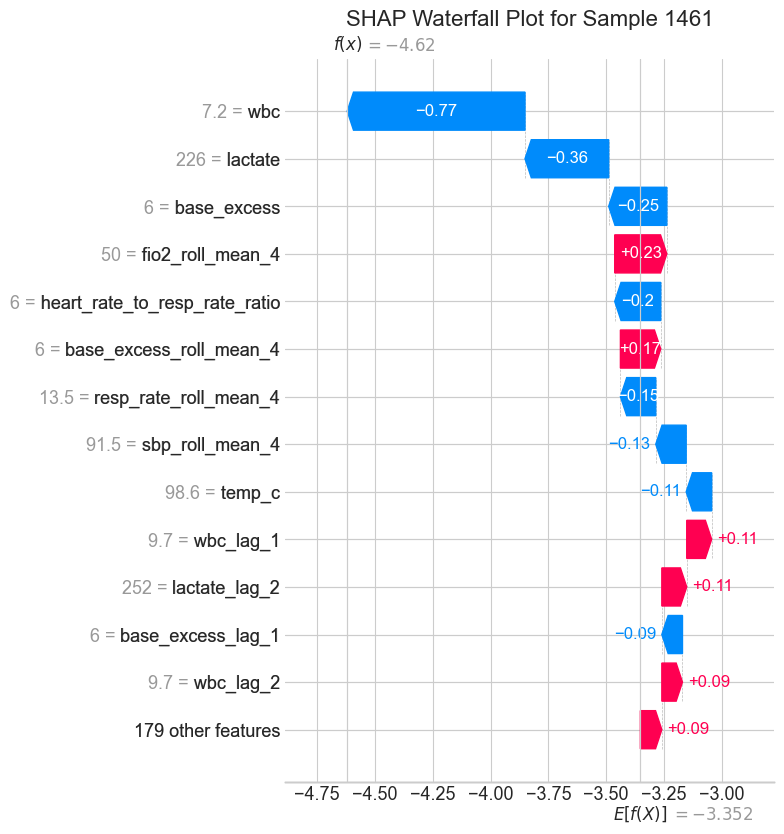

In [19]:
def create_waterfall_plot(model, X_test, feature_names, sample_idx=None):
    """
    Create a waterfall plot for a specific sample using SHAP values
    
    Parameters:
    - model: Trained LightGBM model
    - X_test: Test features
    - feature_names: List of feature names
    - sample_idx: Index of the sample to analyze (if None, a random sample will be selected)
    
    Returns:
    - None (saves plot to file)
    """
    print("Creating SHAP waterfall plot")
    
    # Select a random sample if none specified
    if sample_idx is None:
        sample_idx = np.random.randint(len(X_test))
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Get SHAP values for the selected sample
    try:
        # Try using the legacy method first for backward compatibility
        shap_values = explainer.shap_values(X_test)
        
        # For multi-class problems, take class 1 values
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
            
        # Extract the sample SHAP values
        sample_shap = shap_values[sample_idx]
        
        # Create SHAP Explanation object
        feature_names = X_test.columns.tolist() if hasattr(X_test, 'columns') else feature_names
        base_value = explainer.expected_value
        if isinstance(base_value, list):  # For multi-class models
            base_value = base_value[1]  # Use class 1 (positive class)
            
        explanation = shap.Explanation(
            values=sample_shap,
            base_values=base_value,
            data=X_test.iloc[sample_idx].values if hasattr(X_test, 'iloc') else X_test[sample_idx],
            feature_names=feature_names
        )
    except:
        # If that fails, try the newer method
        try:
            explanation = explainer(X_test.iloc[[sample_idx]] if hasattr(X_test, 'iloc') else X_test[[sample_idx]])
        except Exception as e:
            print(f"Error calculating SHAP values: {str(e)}")
            return
    
    # Create waterfall plot
    plt.figure(figsize=(14, 10))
    try:
        # Create waterfall plot with limited features
        shap.plots.waterfall(explanation, max_display=14, show=False)
        plt.title(f"SHAP Waterfall Plot for Sample {sample_idx}", fontsize=16)
    except Exception as e:
        print(f"Error creating waterfall plot with new API: {str(e)}")
        try:
            # Fall back to the older plot_waterfall function
            shap.plots._waterfall.waterfall_legacy(
                explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                sample_shap,
                X_test.iloc[sample_idx] if hasattr(X_test, 'iloc') else X_test[sample_idx],
                feature_names=feature_names,
                max_display=14
            )
            plt.title(f"SHAP Waterfall Plot for Sample {sample_idx} (Legacy)", fontsize=16)
        except Exception as e2:
            print(f"Error creating legacy waterfall plot: {str(e2)}")
            plt.text(0.5, 0.5, "Error creating waterfall plot", 
                    ha='center', va='center', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/sample_{sample_idx}_waterfall.png", dpi=300)
    
    print(f"Saved waterfall plot for sample {sample_idx}")


# Update the cohort_shapley_analysis_fixed function to include the waterfall plot
def update_shapley_analysis():
    """
    Run the waterfall plot for a random sample
    """
    # Load model
    model_file = f"{OUTPUT_DIR}/icu_mortality_model.pkl"
    try:
        model = joblib.load(model_file)
        print(f"Loaded model from {model_file}")
    except Exception as e:
        print(f"Model file not found: {str(e)}. Please run the main training pipeline first.")
        return
    
    # Load data
    df = load_data(DATA_FILE)
    if df is None:
        print("Failed to load data")
        return
    
    # Extract features by time
    features_dict, time_points = extract_features_by_time(df)
    
    # Prepare patient features
    patient_df = prepare_patient_features(df, features_dict, time_points)
    
    # Handle missing values
    imputed_df = handle_missing_values(patient_df)
    
    # Engineer features
    featured_df = engineer_features(imputed_df)
    
    # Split dataset
    X_train, X_test, y_train, y_test, train_df, test_df = split_dataset(featured_df)
    
    # Get feature columns
    feature_cols = X_train.columns.tolist()
    
    # Create waterfall plot for a random sample
    sample_idx = np.random.randint(len(X_test))
    create_waterfall_plot(model, X_test, feature_cols, sample_idx)
    
    print("Waterfall plot analysis complete")


# If you want to run this directly
if __name__ == "__main__":
    update_shapley_analysis()

In [20]:
# feature selection to check missingness
primary_features = ['heart_rate', 'respiratory_rate', 'temperature', 'systolic_blood_pressure', 'diastolic_blood_pressure']

# time selection to check missingness
initial_df = test_df[test_df['time_step'] <= 30]

# missingness check
patient_has_obs = (
    initial_df
    .groupby('patient_id')[primary_features]
    .apply(lambda df: df.notnull().any().any())  # if there’s at least one feature, it’s true
    .reset_index()
    .rename(columns={0: 'has_primary_vitals'})
)

# merge with test_df
test_with_obs_flag = test_df.merge(patient_has_obs, on='patient_id', how='left')

# Add prediction probabilities to the DataFrames
test_with_obs_flag['prediction_probability'] = model.predict_proba(test_with_obs_flag[X_test.columns])[:, 1] # Get probabilities for class 1

# two groups
group_with_obs = test_with_obs_flag[test_with_obs_flag['has_primary_vitals'] == True]
group_without_obs = test_with_obs_flag[test_with_obs_flag['has_primary_vitals'] == False]

# AUROC
from sklearn.metrics import roc_auc_score

auc_with_obs = roc_auc_score(group_with_obs['icu_mortality'], group_with_obs['prediction_probability'])
# Check if group_without_obs is empty before calculating AUROC
if group_without_obs.empty:
    print("No patients without observed features. Cannot calculate AUROC.")
    auc_without_obs = np.nan  # Assign NaN if empty
else:
    auc_without_obs = roc_auc_score(group_without_obs['icu_mortality'], group_without_obs['prediction_probability'])
auc_overall = roc_auc_score(test_with_obs_flag['icu_mortality'], test_with_obs_flag['prediction_probability'])

print(f"AUROC (with observed features): {auc_with_obs:.4f}")
print(f"AUROC (without observed features): {auc_without_obs}") # Print NaN or the calculated value
print(f"AUROC (overall): {auc_overall:.4f}")

NameError: name 'test_df' is not defined